In [1]:
import numpy as np
import scipy.fftpack as fftpack
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray import Powerspectrum, AveragedPowerspectrum
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/Users/abbie/Documents/GitHub/stingray/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")
/Users/abbie/Documents/GitHub/stingray/stingray/crossspectrum.py:21: UserWarning: Using standard scipy fft
  warnings.warn("Using standard scipy fft")


# Problem 1: damped harmonic oscillator example
Generating a light curve

In [2]:
dt = 0.0001  # time step, in seconds
duration = 200 # length of time, in seconds
omega = 2*np.pi  # angular frequency, in radians
phi = 0.0  # offset angle, in radians

## 1a. Compute the time steps and a cosine harmonic with the above-defined properties.
For plotting ease below, save them as `time` and `oscill`.

In [3]:
time = np.arange(0, duration, dt) # seconds
oscill = np.cos(omega * time + phi)

## 1b. Compute four exponentially damped versions of the harmonic oscillation. 
$$D(t_i) = e^{-\zeta t_i}H(t_i)$$
Pick your own four $\zeta$s! I recommend values between 0.01 and 1.

Save them as `damp1`, `damp2`, etc. 

In [4]:
zeta1 = 0.01
damp1 = np.exp(-time * zeta1) * oscill

Make 3 more damped harmonic oscillators with your own pick of zeta:

In [5]:
zeta2 = 0.2
damp2 = np.exp(-time * zeta2) * oscill
zeta3 = 0.5
damp3 = np.exp(-time * zeta3) * oscill
zeta4 = 1.0 
damp4 = np.exp(-time * zeta4) * oscill

## 1c. Plot them all on top of each other.

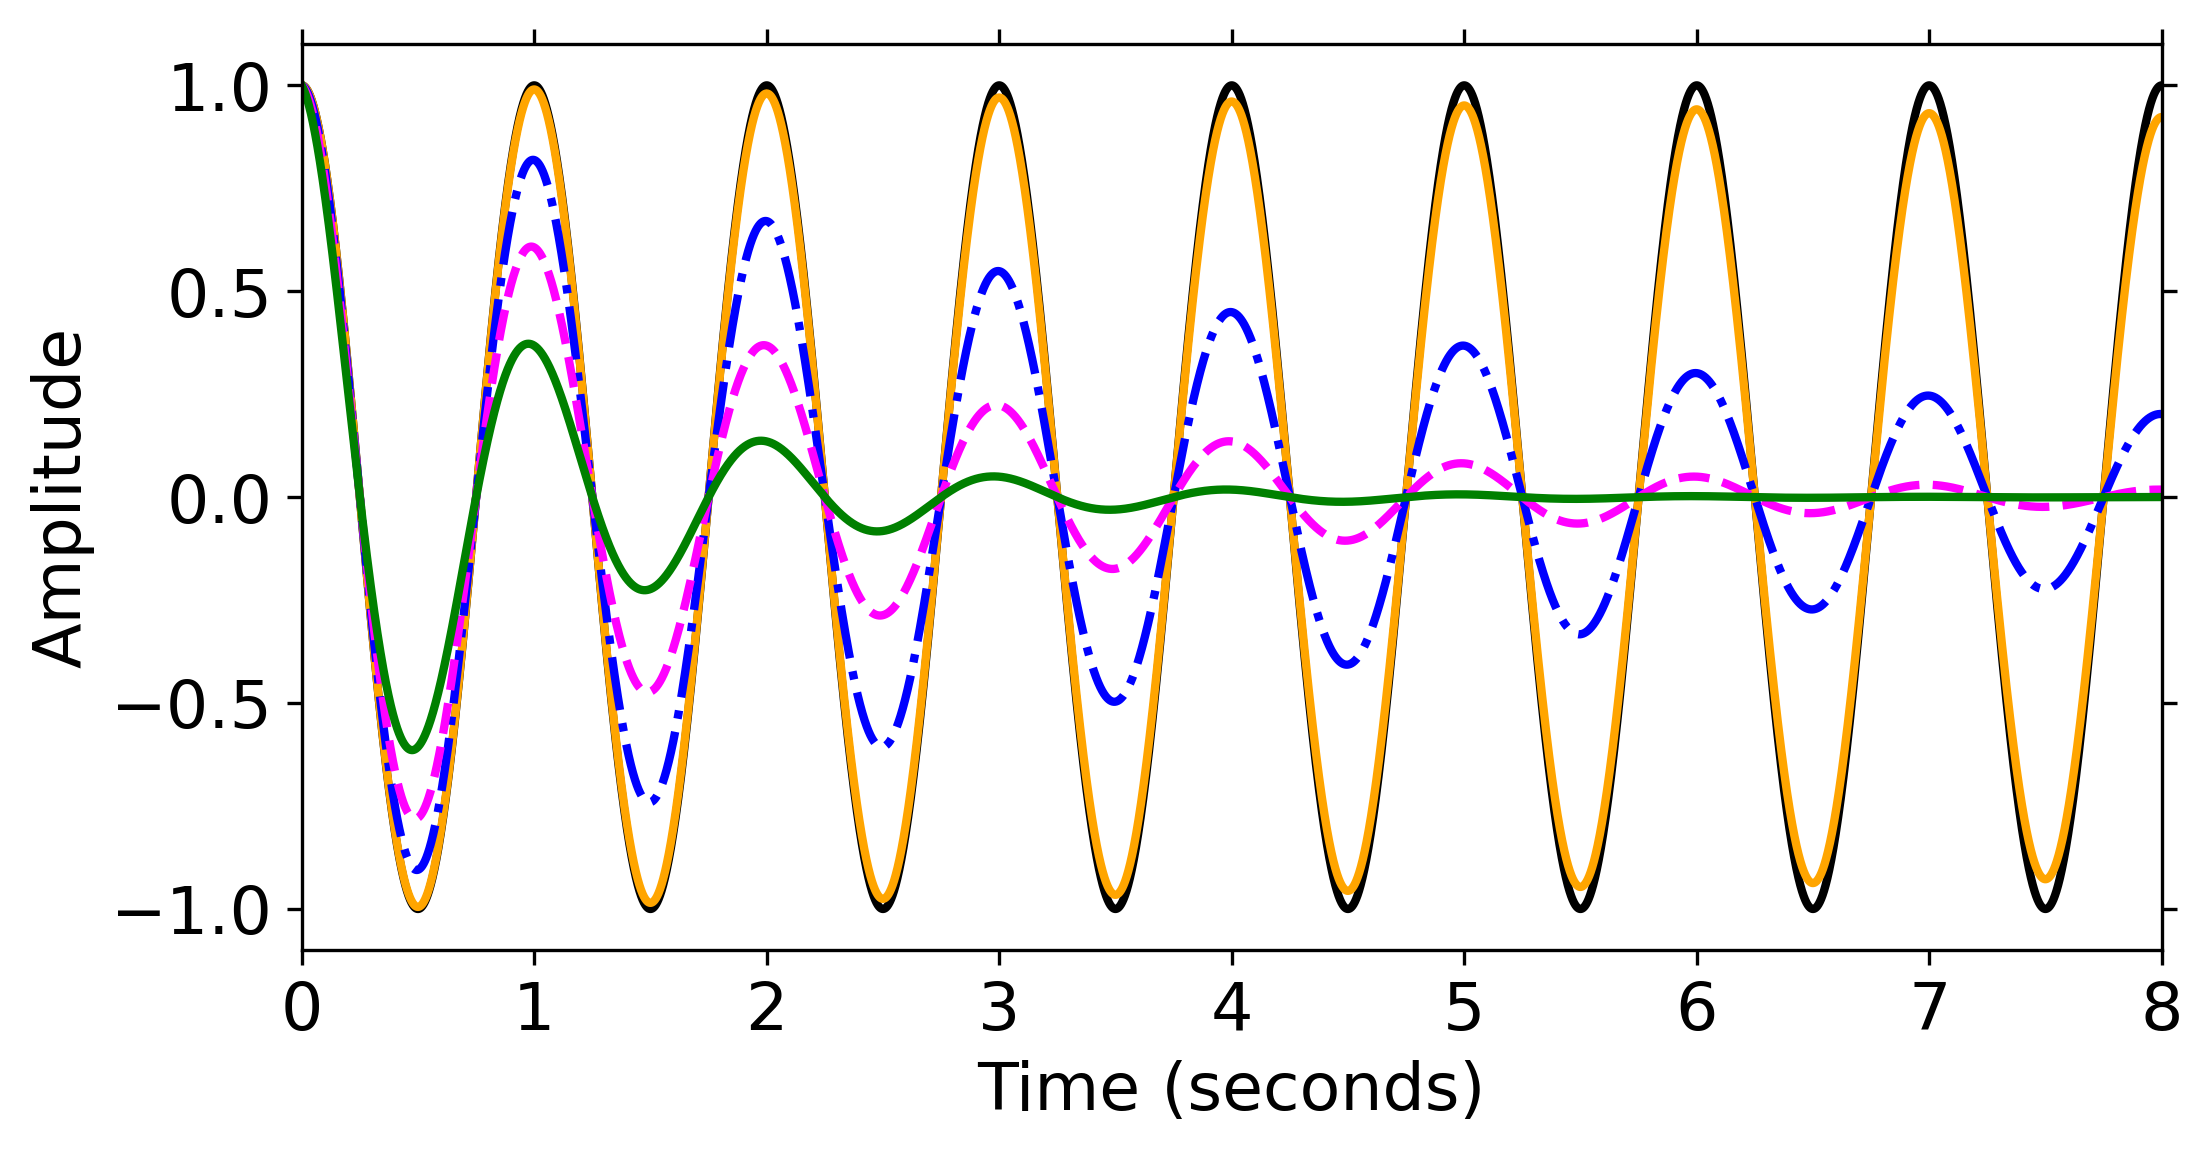

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax.plot(time, oscill, lw=2, linestyle='-', color='black')
ax.plot(time, damp1, lw=2, linestyle='-', color='orange')
ax.plot(time, damp2, lw=2, linestyle='-.', color='blue')
ax.plot(time, damp3, lw=2, linestyle='--', color='magenta')
ax.plot(time, damp4, lw=2, linestyle='-', color='green')
ax.set_xlim(0,8)
ax.set_xlabel("Time (seconds)", fontproperties=font_prop)
ax.set_ylabel("Amplitude", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

## 1d. Take the power spectrum of the harmonic and 4 damped harmonic time series.
The power $P$ at each frequency $\nu_i$, for the Fourier transform $F$, is $$P(\nu_i)=|F(\nu_i)|^2$$
Again, for plotting ease, save as `pow_oscill`, `pow_damp1`, etc.

In [7]:
pow_oscill = np.abs(fftpack.fft(oscill)) ** 2
pow_damp1 = np.abs(fftpack.fft(damp1)) ** 2
pow_damp2 = np.abs(fftpack.fft(damp2)) ** 2
pow_damp3 = np.abs(fftpack.fft(damp3)) ** 2
pow_damp4 = np.abs(fftpack.fft(damp4)) ** 2

Test out what happens if you don't use 'abs'. What data type do you get? 

In [8]:
type(pow_damp1[2])

numpy.float64

## 1e. Plot them! 
Notice the trend between the width of the peak in the power spectrum, and the strength of the damping factor.

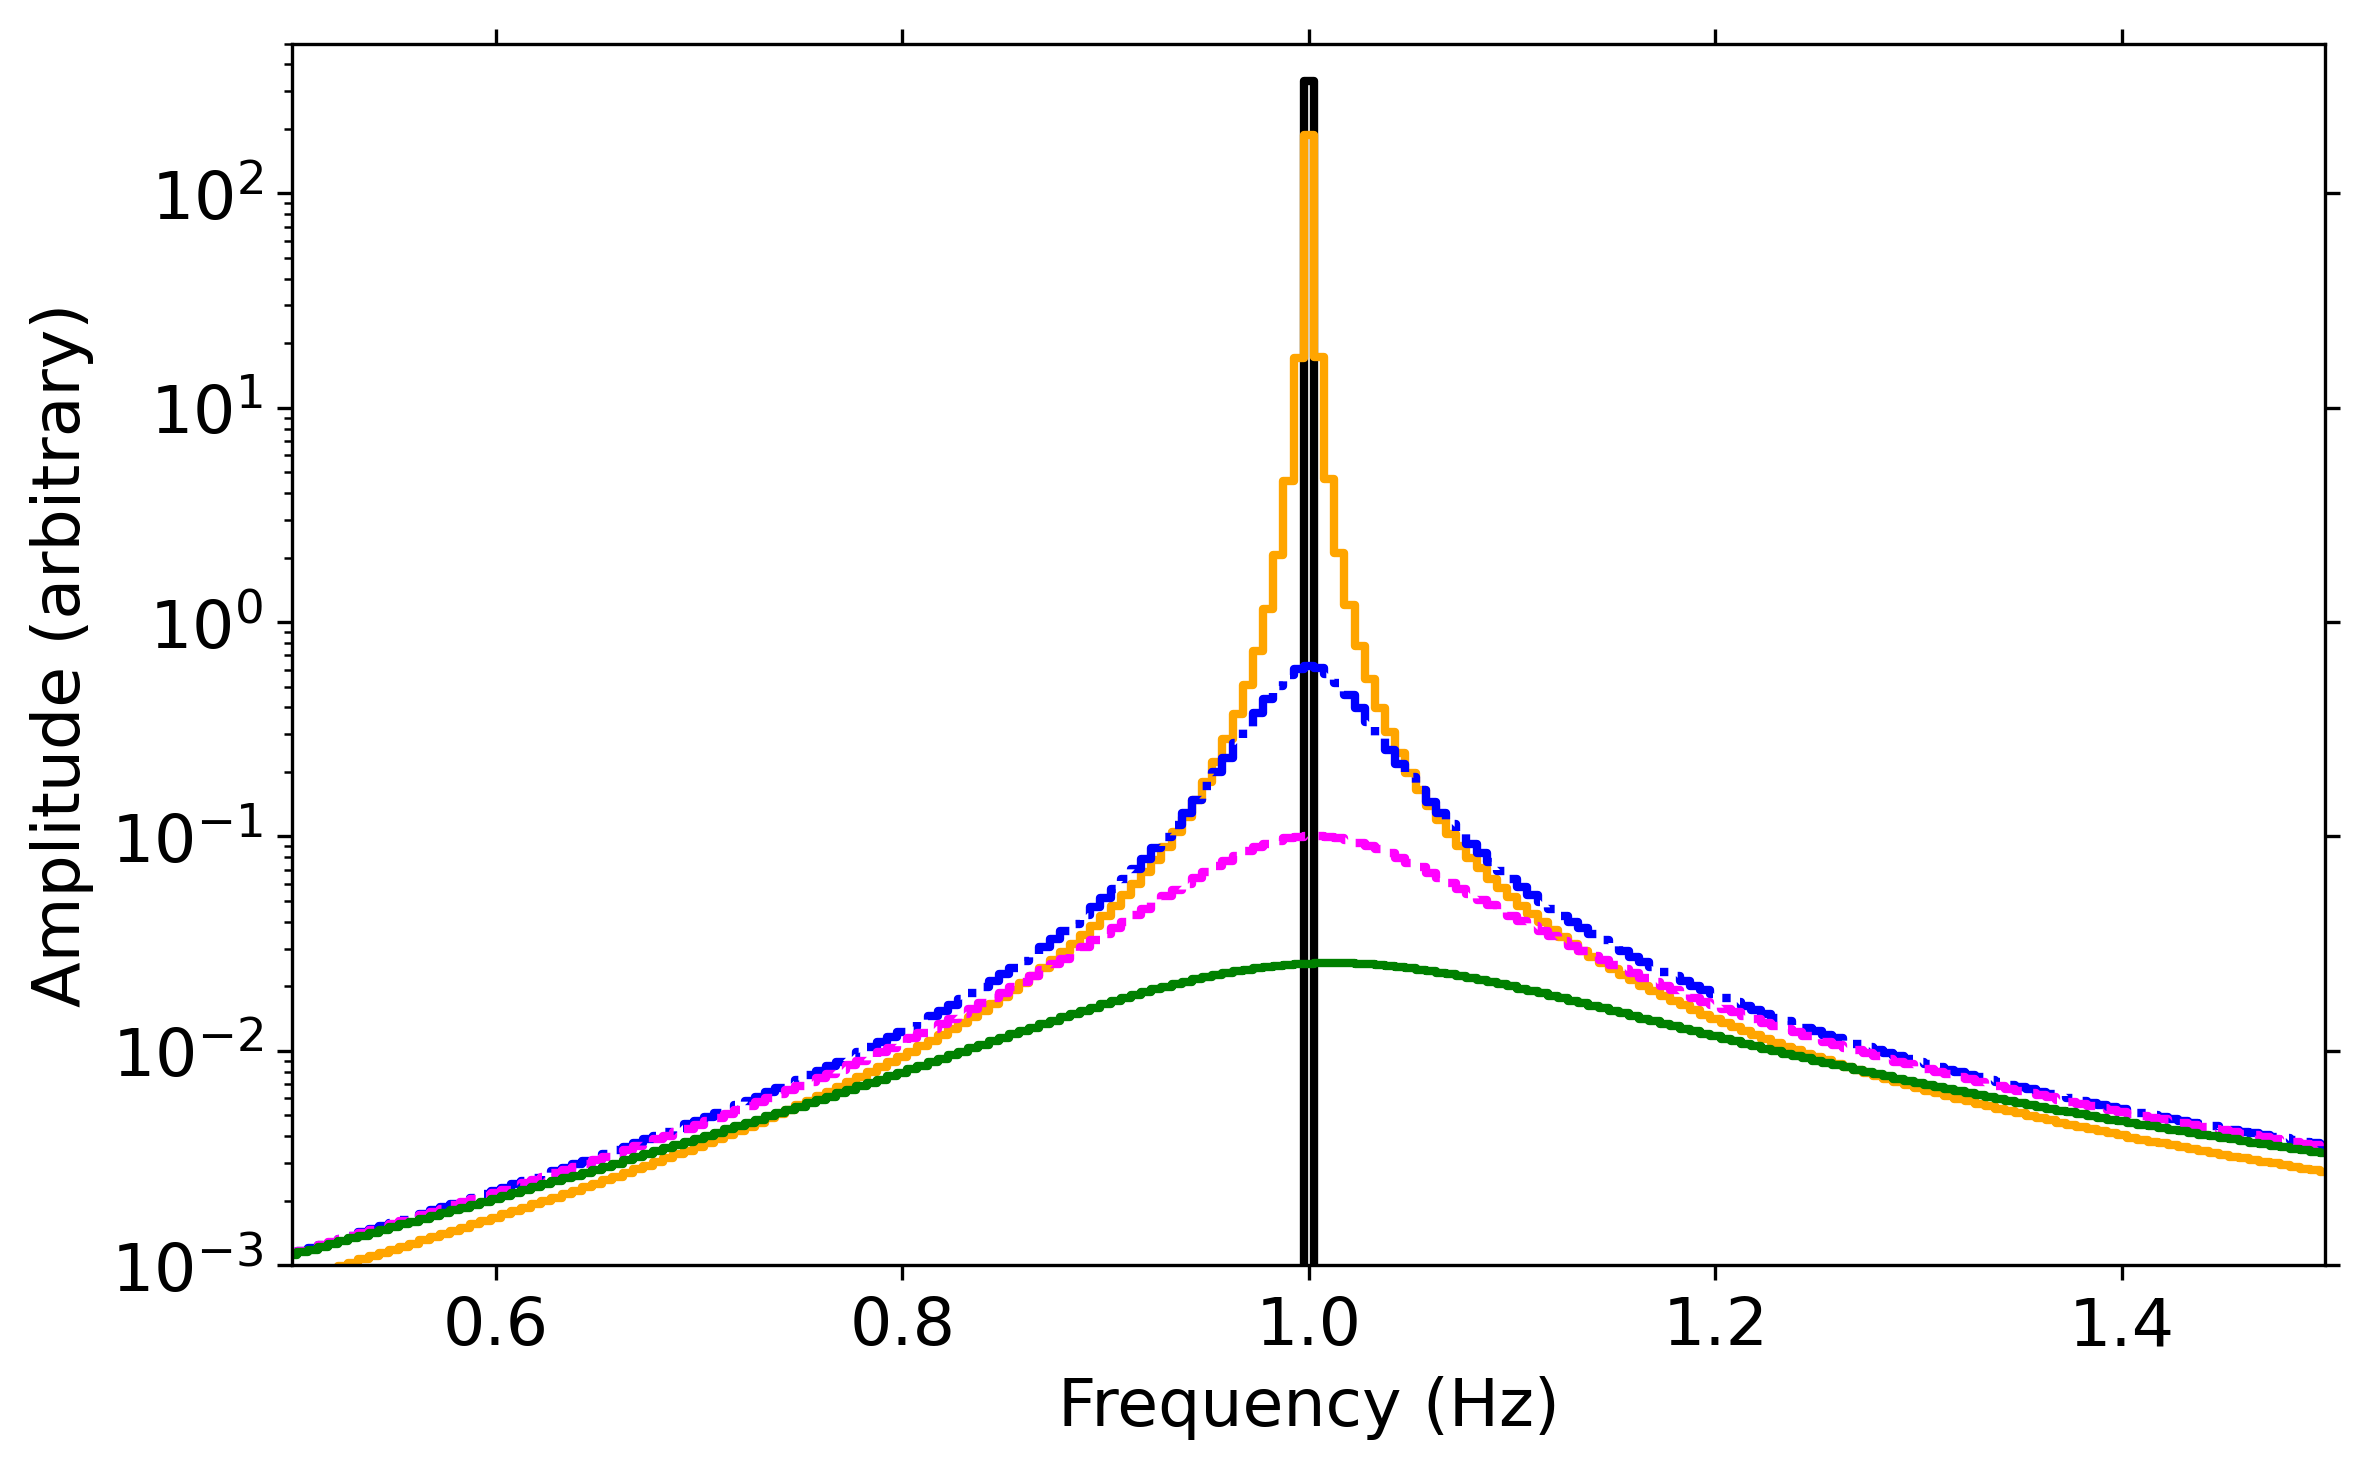

In [9]:
freq = fftpack.fftfreq(len(time), d=dt)
nyq_ind = int(len(time)/2.)  # the index of the last positive Fourier frequency

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(freq[0:nyq_ind], pow_oscill[0:nyq_ind].real/3e9, 
        lw=2, drawstyle='steps-mid', color='black')
ax.plot(freq[0:nyq_ind], pow_damp1[0:nyq_ind].real/1e9, 
        lw=2, drawstyle='steps-mid', linestyle='-', color='orange')
ax.plot(freq[0:nyq_ind], pow_damp2[0:nyq_ind].real/1e9, 
        lw=2, drawstyle='steps-mid', linestyle='-.', color='blue')
ax.plot(freq[0:nyq_ind], pow_damp3[0:nyq_ind].real/1e9, 
        lw=2, drawstyle='steps-mid', linestyle='--', color='magenta')
ax.plot(freq[0:nyq_ind], pow_damp4[0:nyq_ind].real/1e9, 
        lw=2, drawstyle='steps-mid', color='green')
ax.set_xlim(0.5, 1.5)
ax.set_ylim(1e-3, 5e2)
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Amplitude (arbitrary)", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

# 2. Problem 2: Same idea, using Stingray!
Now that you see the math behind the power spectrum, let's start using the spectral-timing library Stingray. Pull up the documentation to help you along.
## 2a. Make a simple `Lightcurve` object from `oscill` and `time`.

In [10]:
lc = Lightcurve(time, oscill, dt=dt, skip_checks=True)

*Look at the warnings!* You already know your timestep `dt` and you know that you lightcurve is sorted (time always increases from lower indices to higher indices), so you can skip those checks here. Look at the Stingray documentation to see how to set these parameters.

## 2b. Try making a power spectrum of that lightcurve using `Powerspectrum`. 

In [11]:
ps = Powerspectrum(lc)
print(ps)

ValueError: 'list' argument must have no negative elements

Ok, you probably see a ValueError above. Let's rethink this. 

The difference between our previous rough-and-tumble power spectrum (squaring the absolute value of the Fourier transform) and Stingray's `Powerspectrum` is that Stingray expects its data to be photon counts. Our sample data goes negative (since we were doing a simple case of deviations from a mean value of 0), but Stingray knows that you can't detect negative photons! 

## 2c. Getting the sample data in the right format for Stingray
So, to make our data fit Stingray's expectation, multiply our light curve `oscill` by a scaling factor and add a mean photon count rate value to that scaled light curve (anywhere from 100 to 1000 is a reasonable X-ray photon counts/second). Since Stingray expects the count rate as counts per time bin (not counts per second), the counts must be an integers. Hint: `np.rint` can be a helpful method.

In [12]:
temp = np.rint(oscill*2)+2
lc = Lightcurve(time, temp, dt=dt, skip_checks=True)
print(lc.counts)

[4. 4. 4. ... 4. 4. 4.]


Plot `.time` vs `.counts`

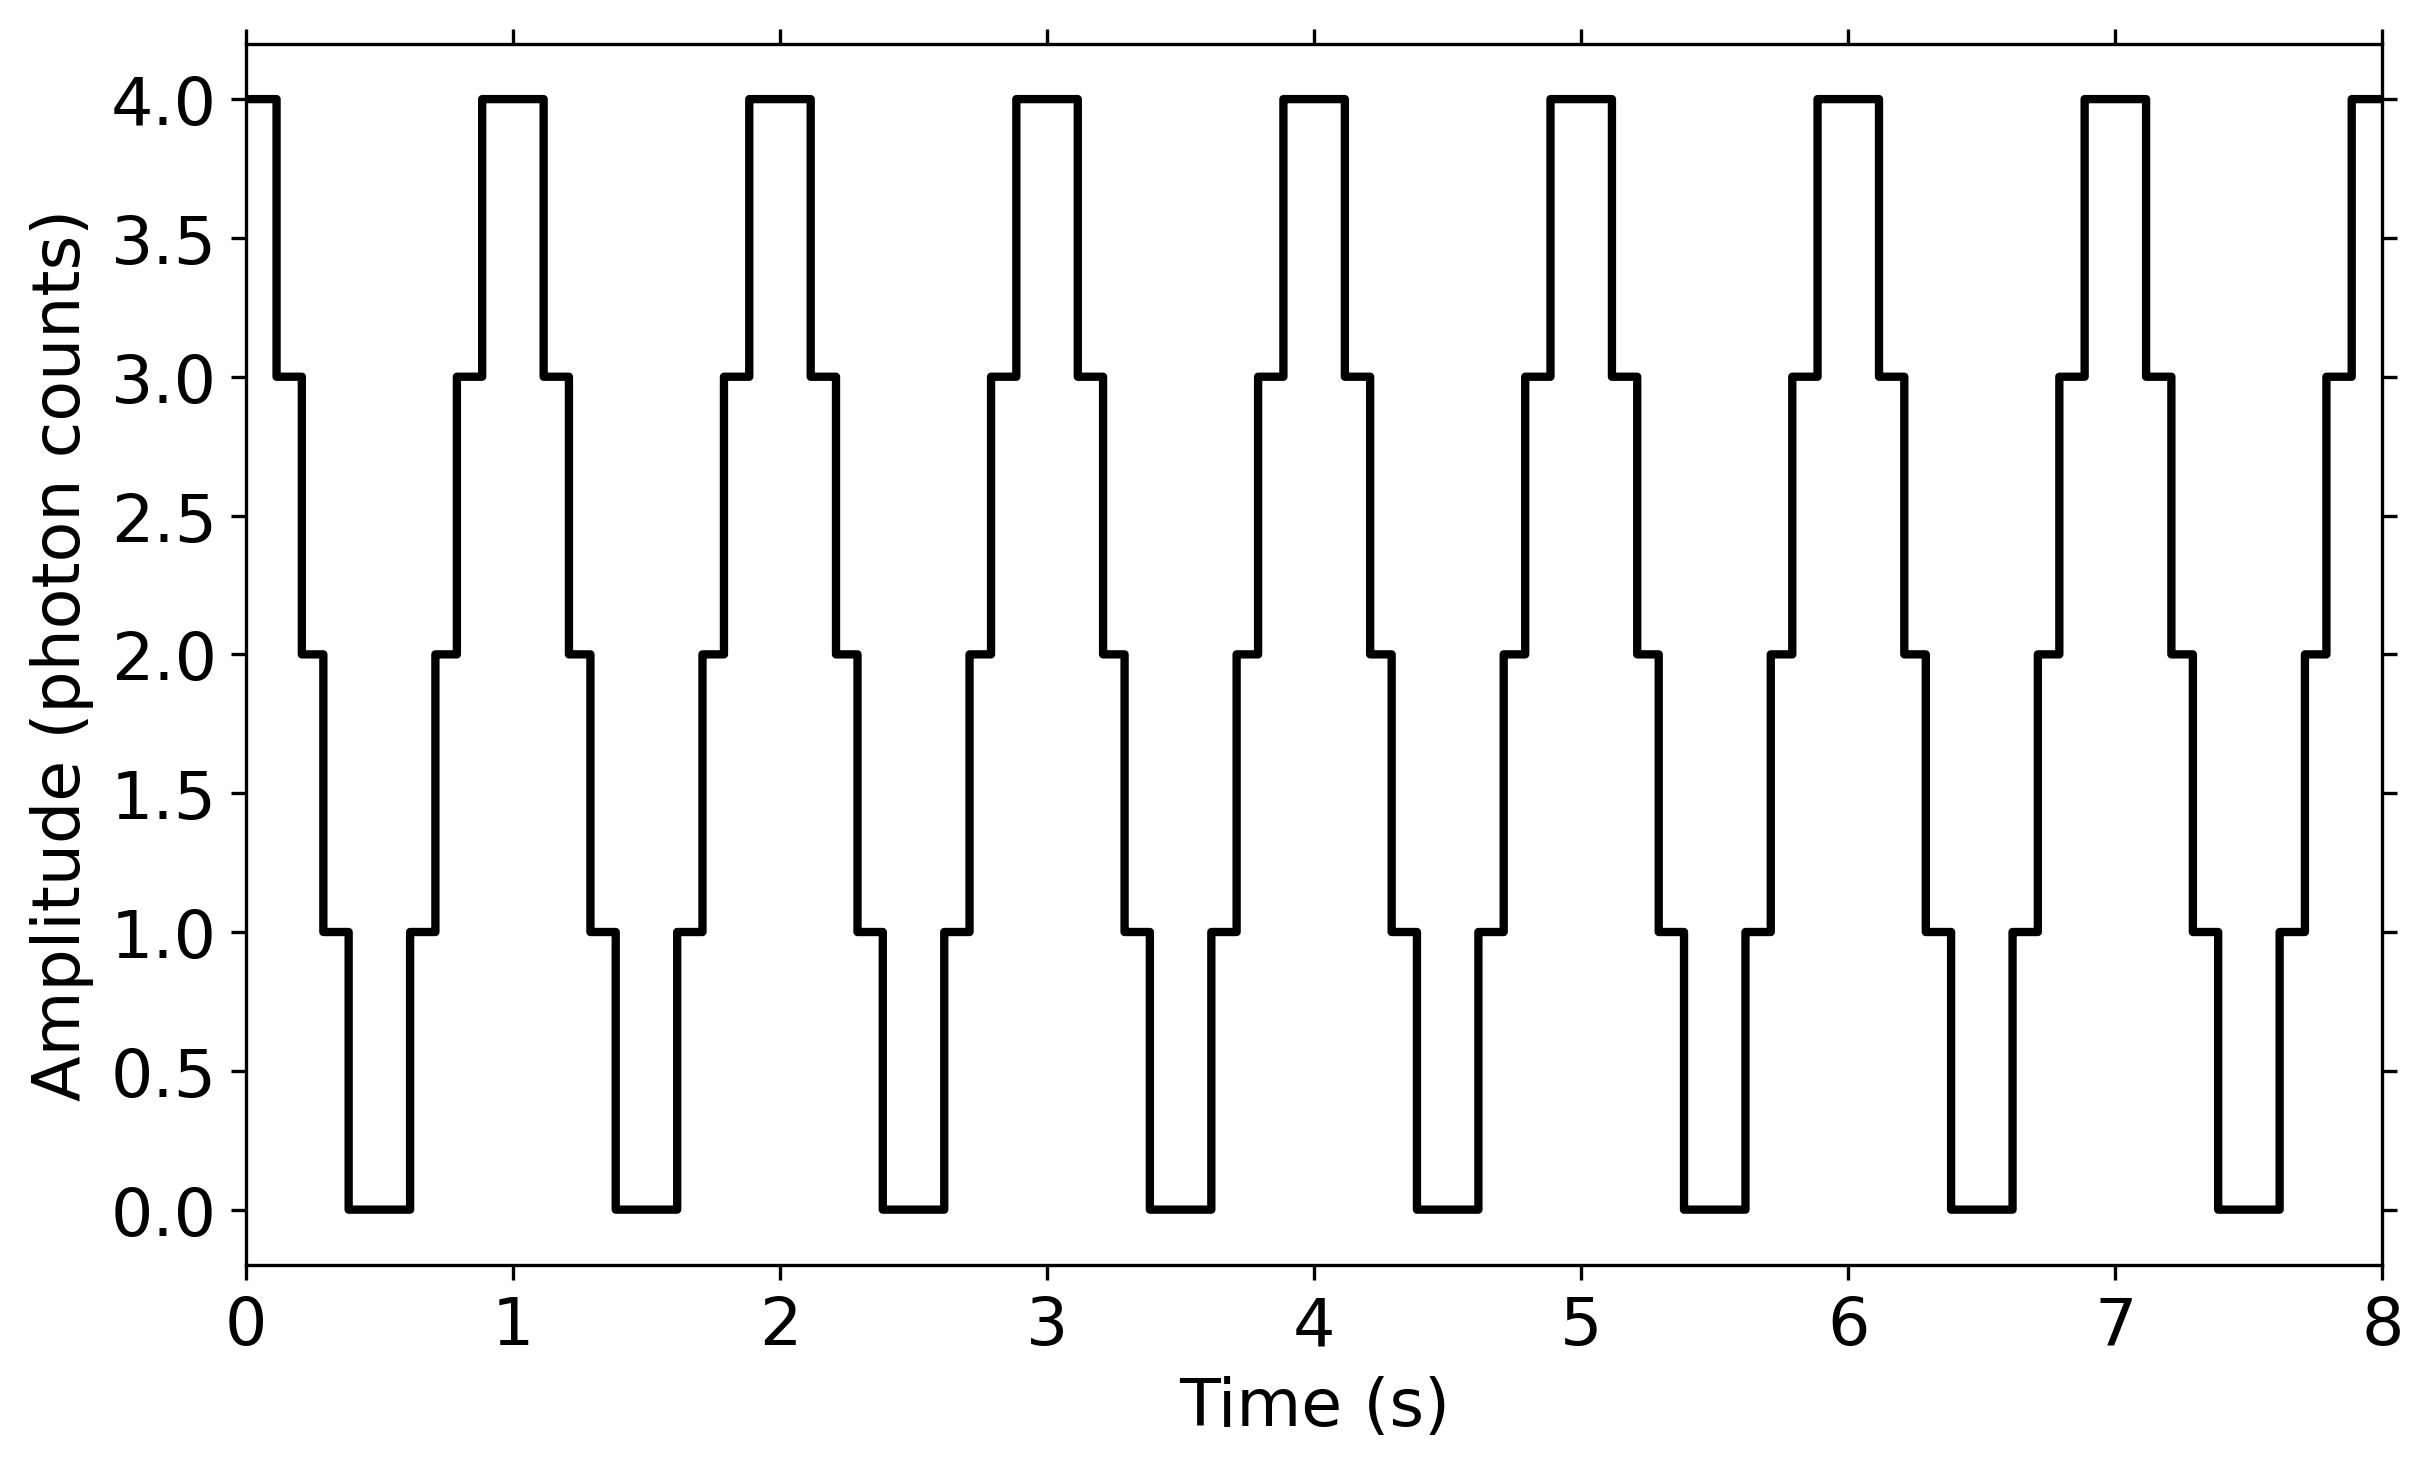

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(lc.time, lc.counts, lw=2, drawstyle='steps-mid', color='black')
ax.set_xlim(0,8)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Amplitude (photon counts)", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

## 2d. Now make a power spectrum of that light curve using Stingray, and the light curves and power spectra for the four damped harmonic oscillators.

In [14]:
ps = Powerspectrum(lc)

In [15]:
lc1 = Lightcurve(time, np.rint(damp1*2)+2, dt=dt, skip_checks=True)
ps1 = Powerspectrum(lc1)
print(np.max(ps.power))
lc2 = Lightcurve(time, np.rint(damp2*2)+2, dt=dt, skip_checks=True)
ps2 = Powerspectrum(lc2)
lc3 = Lightcurve(time, np.rint(damp3*2)+2, dt=dt, skip_checks=True)
ps3 = Powerspectrum(lc3)
lc4 = Lightcurve(time, np.rint(damp4*2)+2, dt=dt, skip_checks=True)
ps4 = Powerspectrum(lc4)

107.64559856627915


Plot the power spectra! No need to compute the Nyquist frequency like we did in problem 1, since Stingray's default is only to keep and plot the positive Fourier frequencies.

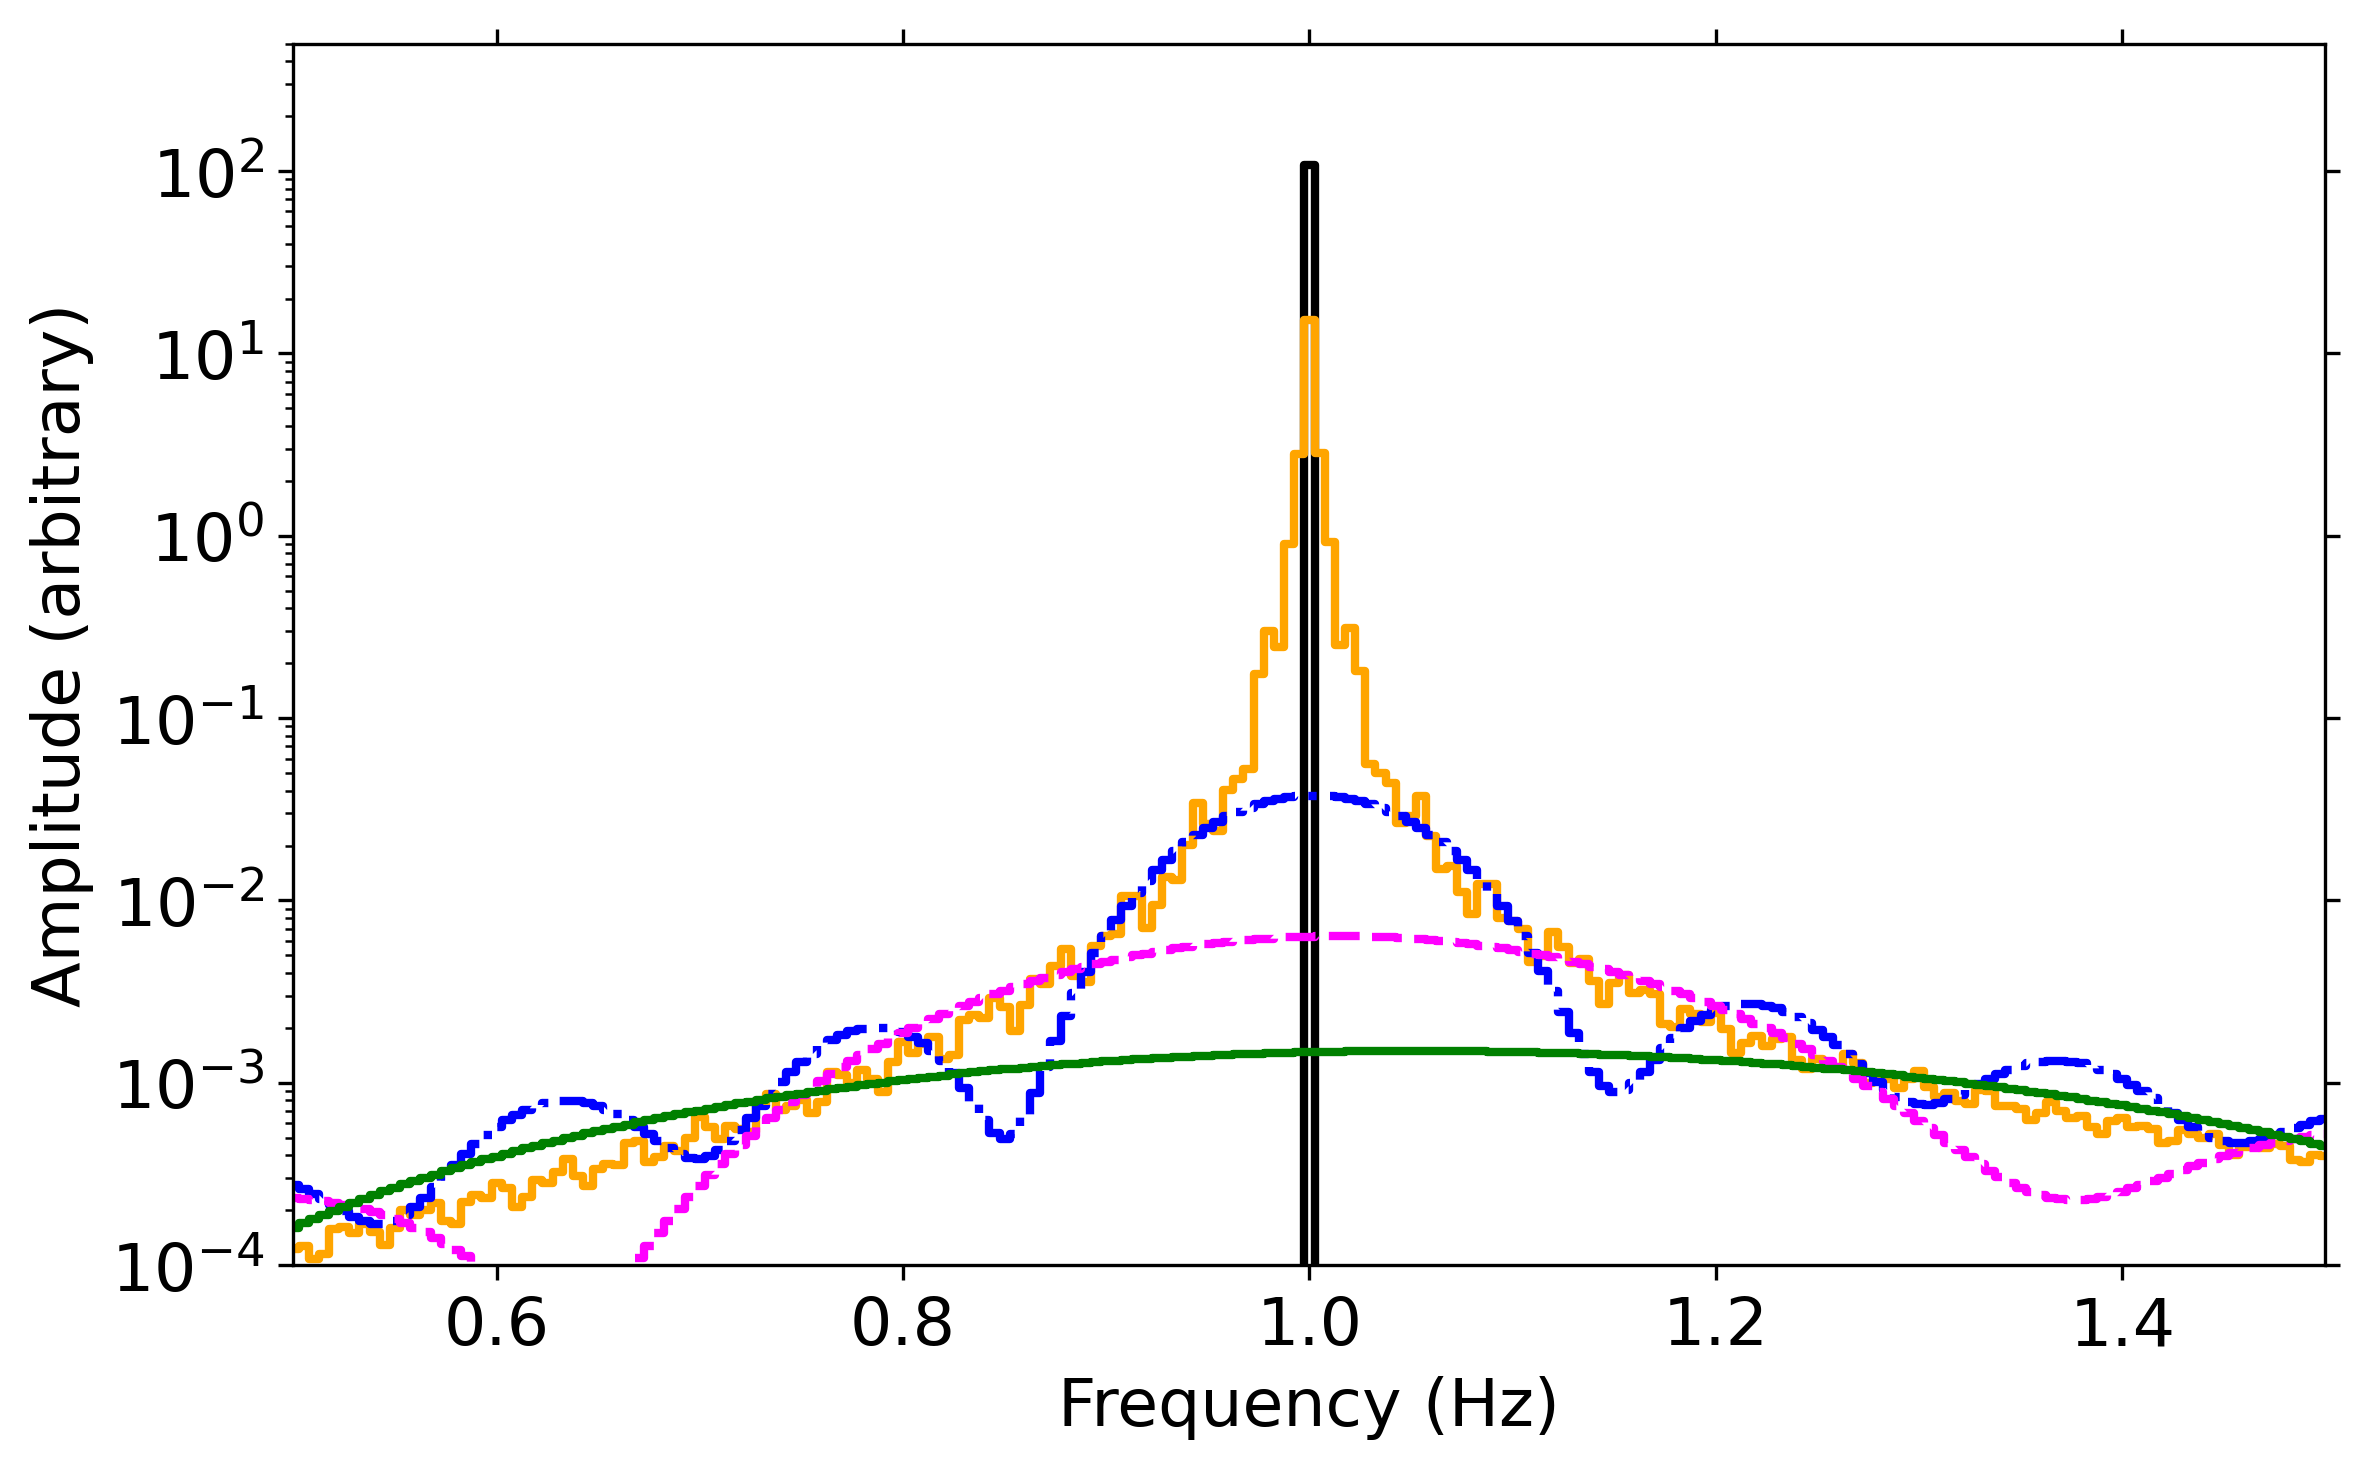

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps.freq, ps.power, lw=2, drawstyle='steps-mid', color='black')
ax.plot(ps1.freq, ps1.power, lw=2, drawstyle='steps-mid', linestyle='-', color='orange')
ax.plot(ps2.freq, ps2.power, lw=2, drawstyle='steps-mid', linestyle='-.', color='blue')
ax.plot(ps3.freq, ps3.power, lw=2, drawstyle='steps-mid', linestyle='--', color='magenta')
ax.plot(ps4.freq, ps4.power, lw=2, drawstyle='steps-mid', color='green')
ax.set_xlim(0.5, 1.5)
ax.set_ylim(1e-4, 5e2)
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Amplitude (arbitrary)", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

Remember, the reason we are plotting right around 1 Hz is because we defined the time series to have that frequency. With real data, you don't want to zoom in your plots like that initially.

# Problem 3: Analyzing *NICER* data of the black hole X-ray binary MAXI J1535-571 

Import it with astropy tables from the file "J1535_evt.fits", and call it `j1535`.

In [17]:
j1535 = Table.read("./J1535_evt.fits", format='fits')

The data have come to us as an 'event list', meaning that it's a list of the time at which a photon was detected (in seconds, in spacecraft clock time)  and the energy of the photon (a detector channel integer; channel/100=photon energy in keV). 

## 3a. Turn this list of photons into an evenly-spaced light curve 
### 3a.i. 
First, clean it up a little by only keeping photons with energies greater than 1 keV and less than 12 keV, using array masking. 

In [18]:
print(len(j1535))
energy_mask = (j1535['ENERGY'] >= 100) & (j1535['ENERGY'] <= 1200)
j1535 = j1535[energy_mask]
print(len(j1535))

42242715
41895664


Printing the lengths to show how many events were removed with this filter.

### 3a.ii. 
Use Stingray's method `Lightcurve.make_lightcurve` to turn this event list into a light curve with evenly spaced time bins and photon counts per bin. Pick a light curve time resolution of `dt=1/8`seconds to start with.

In [19]:
lc_j1535 = Lightcurve.make_lightcurve(j1535['TIME'], dt=1./8)

These things might take a second; you're using half a million time bins in your light curve! I sometimes check the min and max of a light curve, to be sure that there wasn't an error.

In [20]:
np.max(lc_j1535.countrate)

18720.0

In [21]:
np.min(lc_j1535.countrate)

0.0

## 3b. Let's try taking the power spectrum of it.

In [22]:
ps = Powerspectrum(lc_j1535)

Plot it!

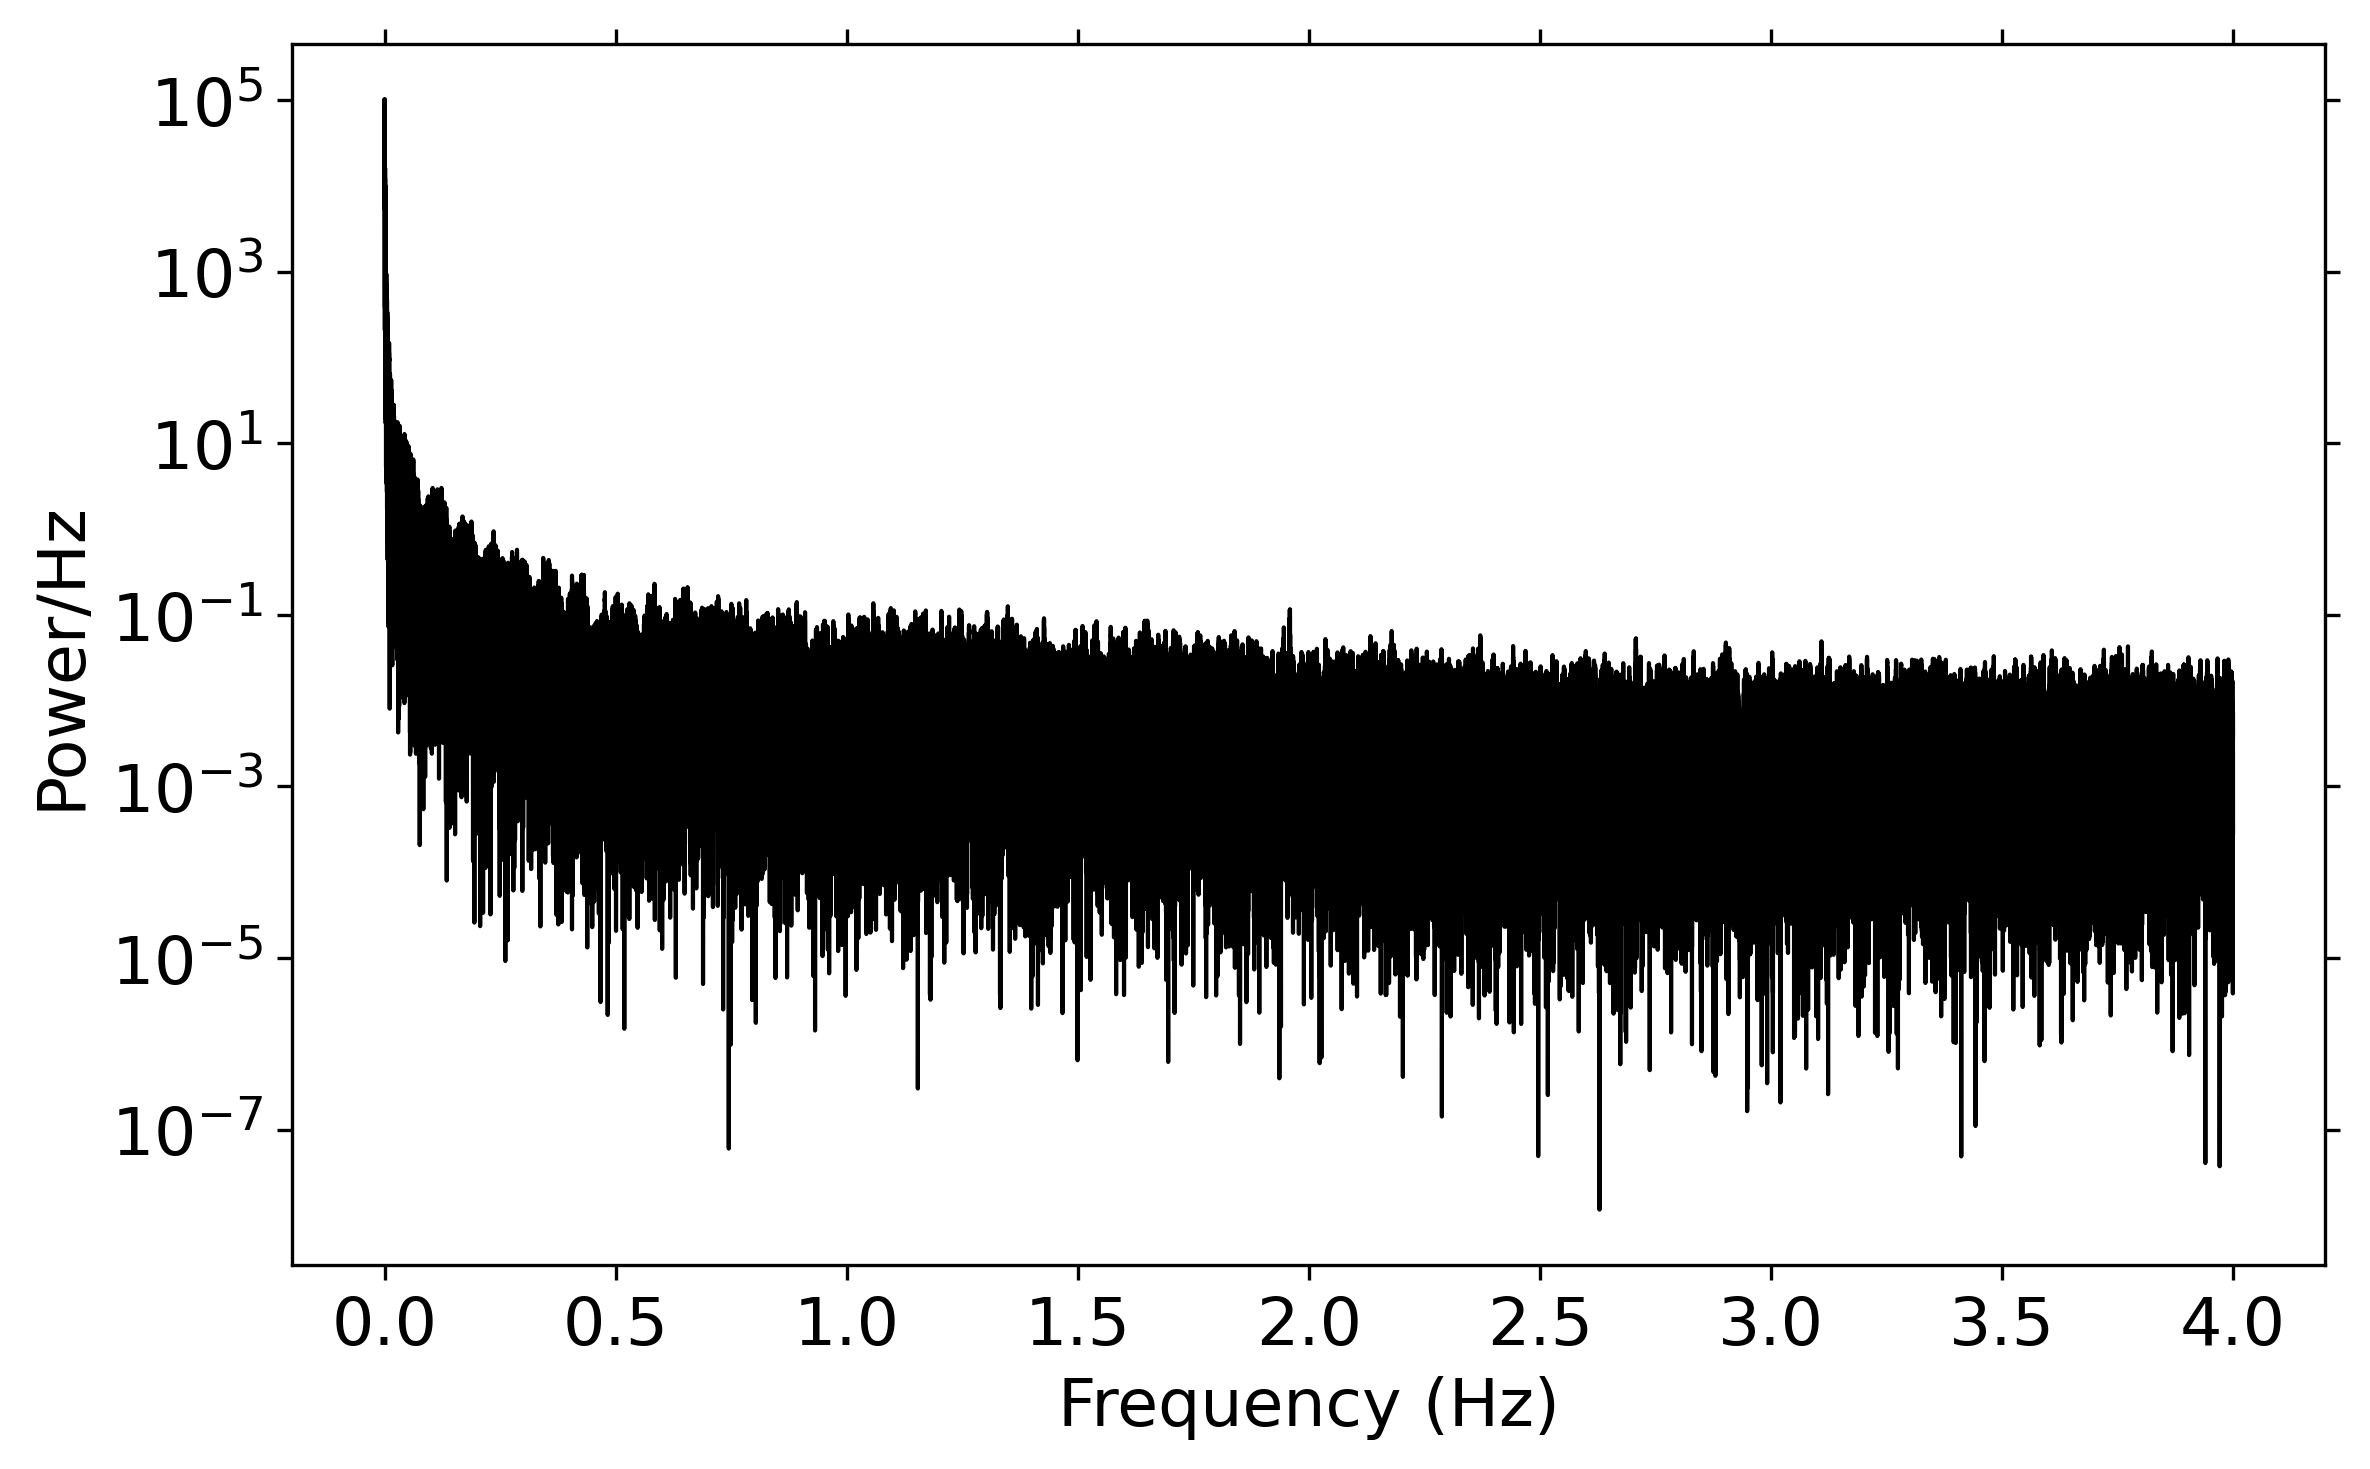

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps.freq, ps.power, lw=1, drawstyle='steps-mid', color='black')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

It's ugly! But more importantly, you can't get useful science out of it. 
## What's going on?
1. There are gaps in the light curve (see below) due to the orbit of the spacecraft (and occasionally stuff gets in the way). This has the effect of inserting top-hat windows into our function, which give the lumpy bumps at ~0.25 Hz. So, we need to break the light curve up into shorter segments that won't have weird drop-outs.
2. There is a giant DC component at $\nu=0$. This is not astrophysical in origin, but from the mean of the light curve.
3. Power spectra are often plotted on log-log scales, but the power gets really noisy and 'scattery' at higher frequencies. 
4. The eagle-eyed observer will notice that we can only go up to a Nyquist frequency of 4 Hz. There are interesting astrophysical signals above 4 Hz, but if we did smaller `dt` with keeping the very long segment length, we'd have >1 million time bins, which can be asking a lot of a laptop processor. 

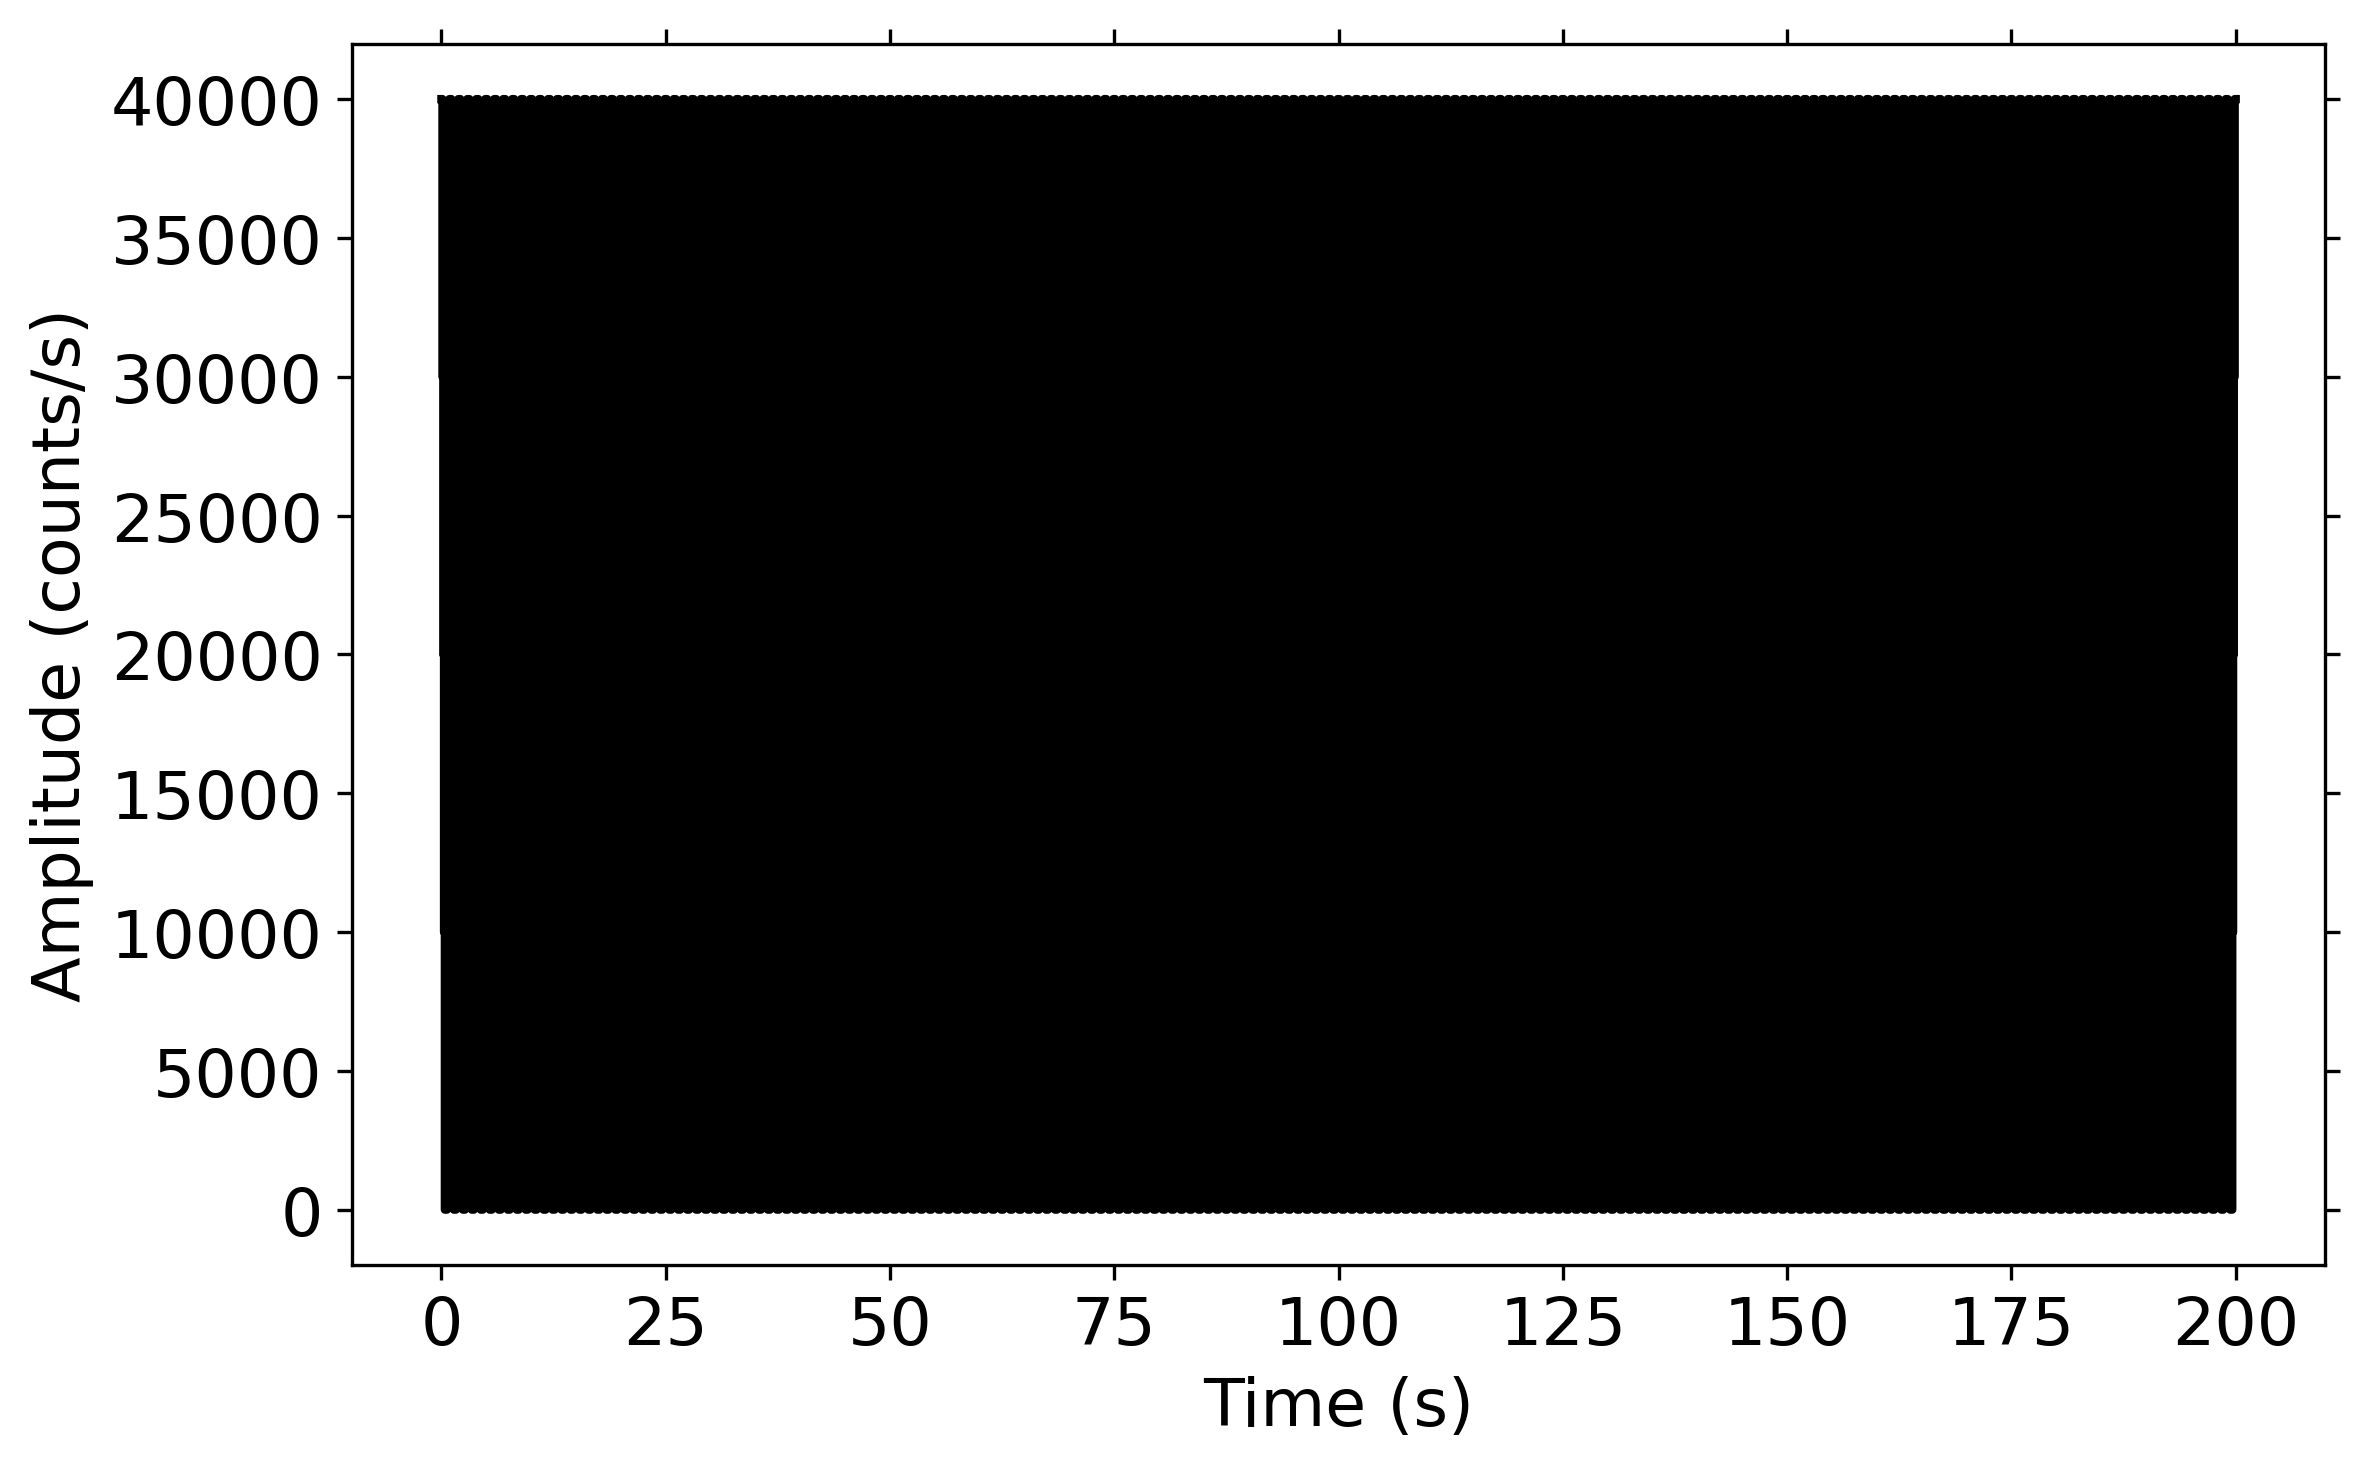

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(lc.time, lc.countrate, lw=2, drawstyle='steps-mid', color='black')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Amplitude (counts/s)", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

## 3c. Segments!

## 3c.i. GTIs
Sometimes, the detector is on and recording photons, but it's pointed too close to the Earth, or a structure on the spacecraft is occulting part of the view, or the instrument is moving through a zone of high particle background, or other things. The times when these things happen are recorded, and in data reduction you make a list of Good Time Intervals, or GTIs, which is when you can use good science data. I made a list of GTIs for this data file that are longer than 4 seconds long, which you can read in from "J1535_gti.fits", and call it `gti_tab`.

In [25]:
gti_tab = Table.read("./J1535_gti.fits", format='fits')
gti_tab

START,STOP
float64,float64
117352030.0,117352785.0
117352787.0,117352802.0
117357673.0,117358342.0
117363425.0,117363885.0
117363889.0,117363902.0
117413166.0,117413905.0
117413907.0,117413922.0


Stingray needs the gtis as a list of start and stop time pairs.

In [26]:
gtis = [[i,j] for (i,j) in zip(gti_tab['START'], gti_tab['STOP'])]

### 3c.ii. Segments
Not only do we want to only use data in the GTIs, but we want to split the light curve up into multiple equal-length segments, take the power spectrum of each segment, and average them together, using `AveragedPowerspectrum`. By using shorter time segments like `segment_size=32` seconds, we can use a finer `dt` like 1/64 sec on the light curves, without having so many bins for each computation that our computer grinds to a halt. There is the added bonus that the noise amplitudes will tend to cancel each other out, and the signal amplitudes will add, and we get better signal-to-noise! When calculating this averaged power spectrum here, use `norm=none`.

Make a new `Lightcurve` object of the data and the averaged power spectrum of that lightcurve with these recommended properties.

As you learned in lecture, setting the length of the segment determines the lowest frequency you can probe, but for stellar-mass compact objects where we're usually interested in variability above ~0.1 Hz, this is an acceptable trade-off.

In [27]:
lc_new = Lightcurve.make_lightcurve(j1535['TIME'], dt=1./64, gti=gtis)
ps_new = AveragedPowerspectrum(lc_new, segment_size=32, norm='none')

Plot it! Note that the Good Times Intervals are saved to the `Lightcurve` object, but won't appear to be applied to the plotted data.

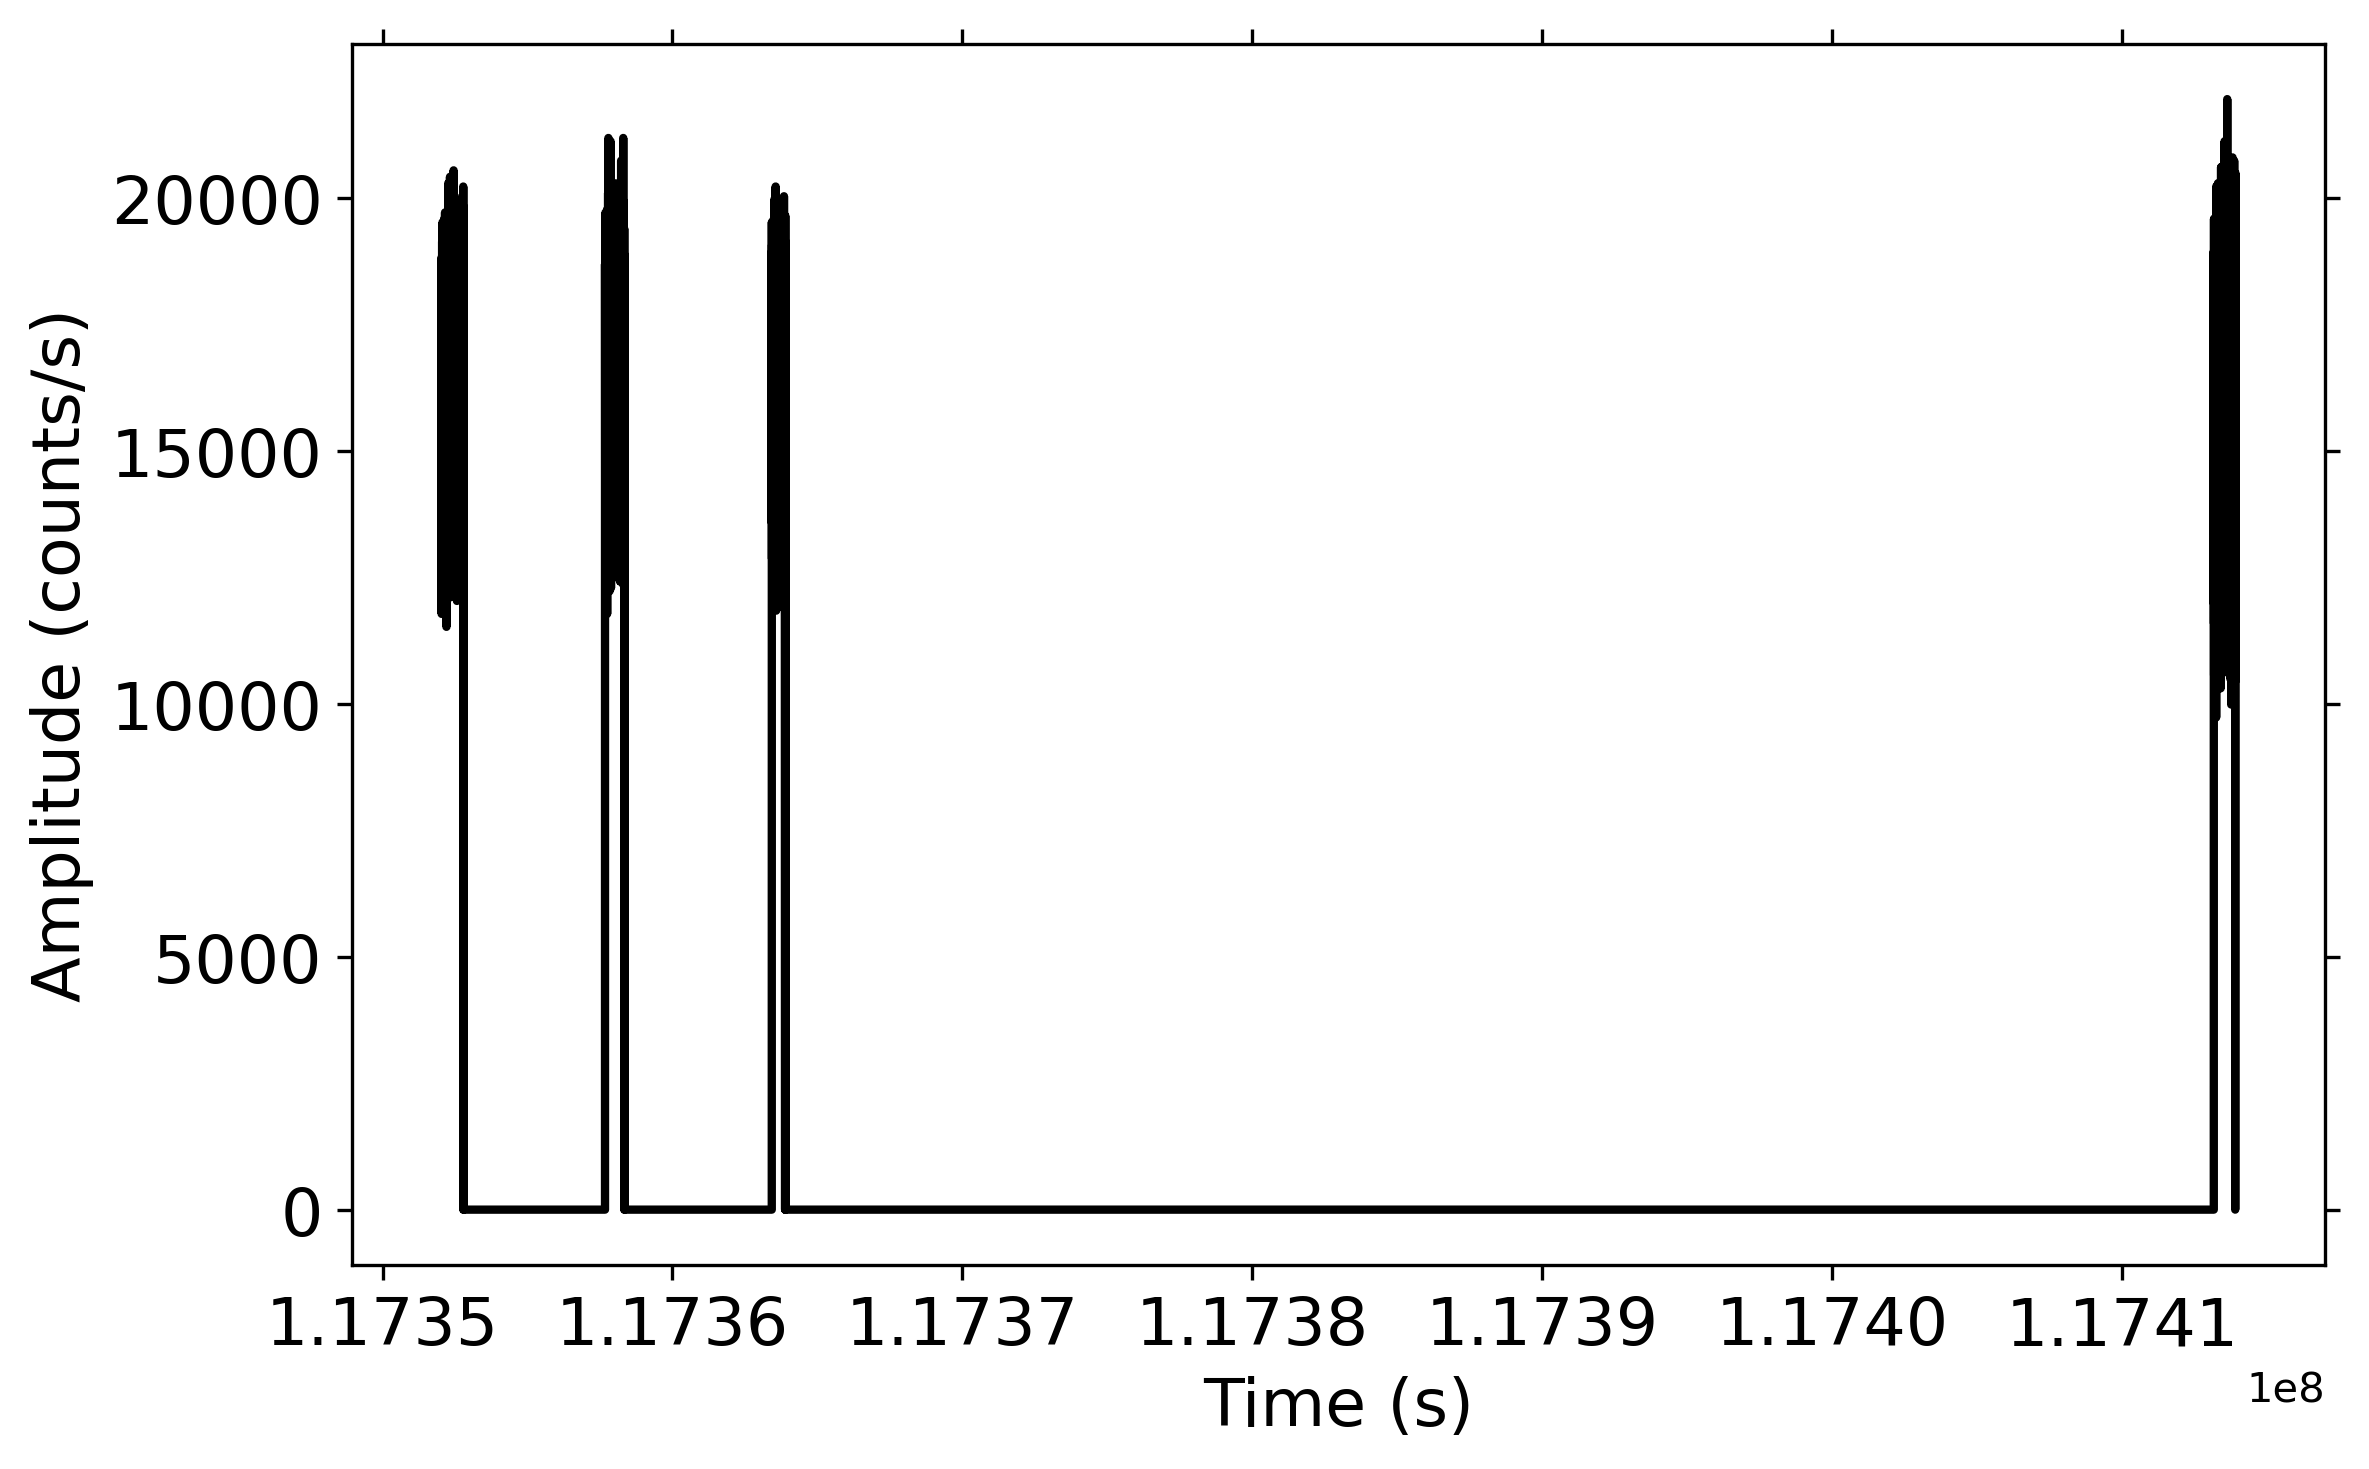

In [28]:
# The counts per second should be the same, regardless of your time binning!
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(lc_new.time, lc_new.countrate, lw=2, drawstyle='steps-mid', color='black')
# ax.set_xlim(0,8)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Amplitude (counts/s)", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

/Users/abbie/opt/anaconda3/envs/j0243/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


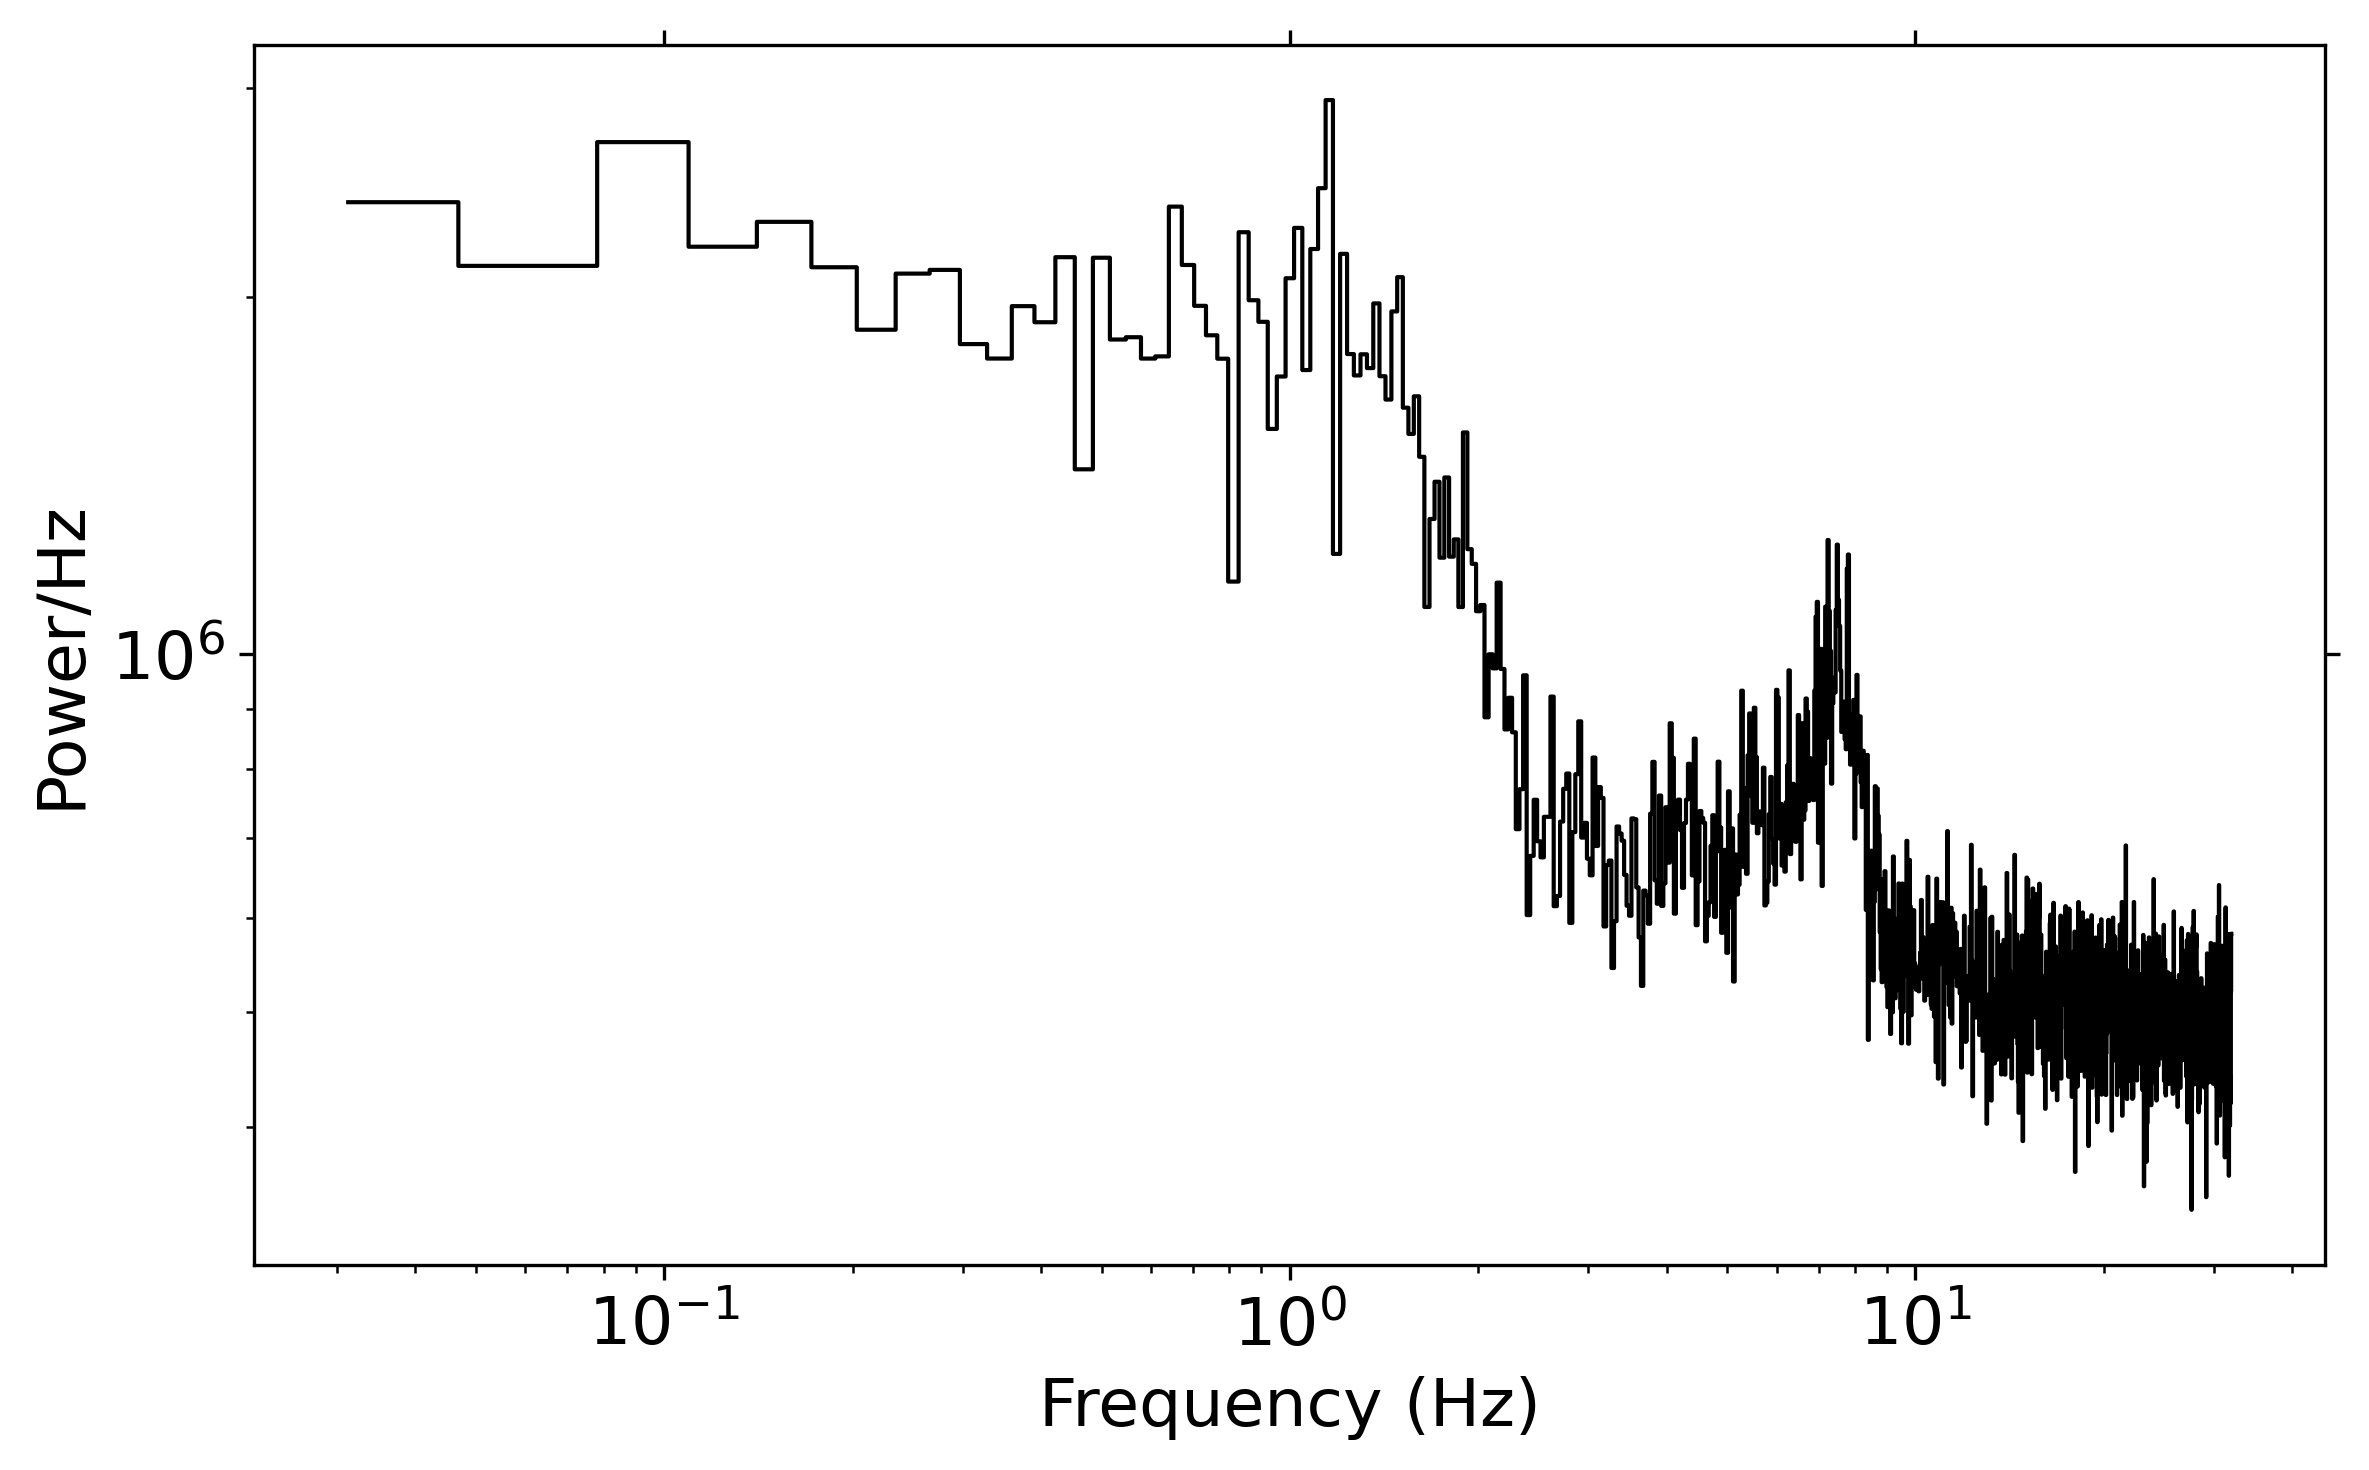

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps_new.freq, ps_new.power, lw=1, drawstyle='steps-mid', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

Now, we've also applied logarithmic scales to the x and y axes in addition to using the GTIs. You can see something just to the left 10 Hz much clearer!
The sharp signal in the lowest frequency bin is called the 'DC component', which is not astrophysical and arises from the mean count rate of the light curve. For ease, we typically plot these starting at frequency bin index 1 instead of index 0. If you're calculating your own power spectra with Fourier transforms outside of Stingray, subtract the mean counts/s from the light curve (in counts/s) before taking the Fourier transform.

## 3d. Error on average power
The average power at a particular frequency has a chi-squared distribution with two degrees of freedom about the true underlying power spectrum. So, error is the value divided by the root of the number of segments (`M` in Stingray). A big reason why we love power spectra(/periodograms) is because this is so straight forward! 

$\text{error} = \frac{\text{power}}{\sqrt{M}}$

One way to intuitively check if your errors are way-overestimated or way-underestimated is whether the size of the error bar looks commeasurate with the amount of bin-to-bin scatter of power at neighbouring frequencies.

In [30]:
ps_new.power_err

array([399919.7416095 +0.j, 347001.19739008+0.j, 427880.3425299 +0.j, ...,
        70928.39315606+0.j,  80985.42594583+0.j,  96142.92742953+0.j])

Plotting, this time with `ax.errorbar` instead of `ax.plot`.

/Users/abbie/opt/anaconda3/envs/j0243/lib/python3.8/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


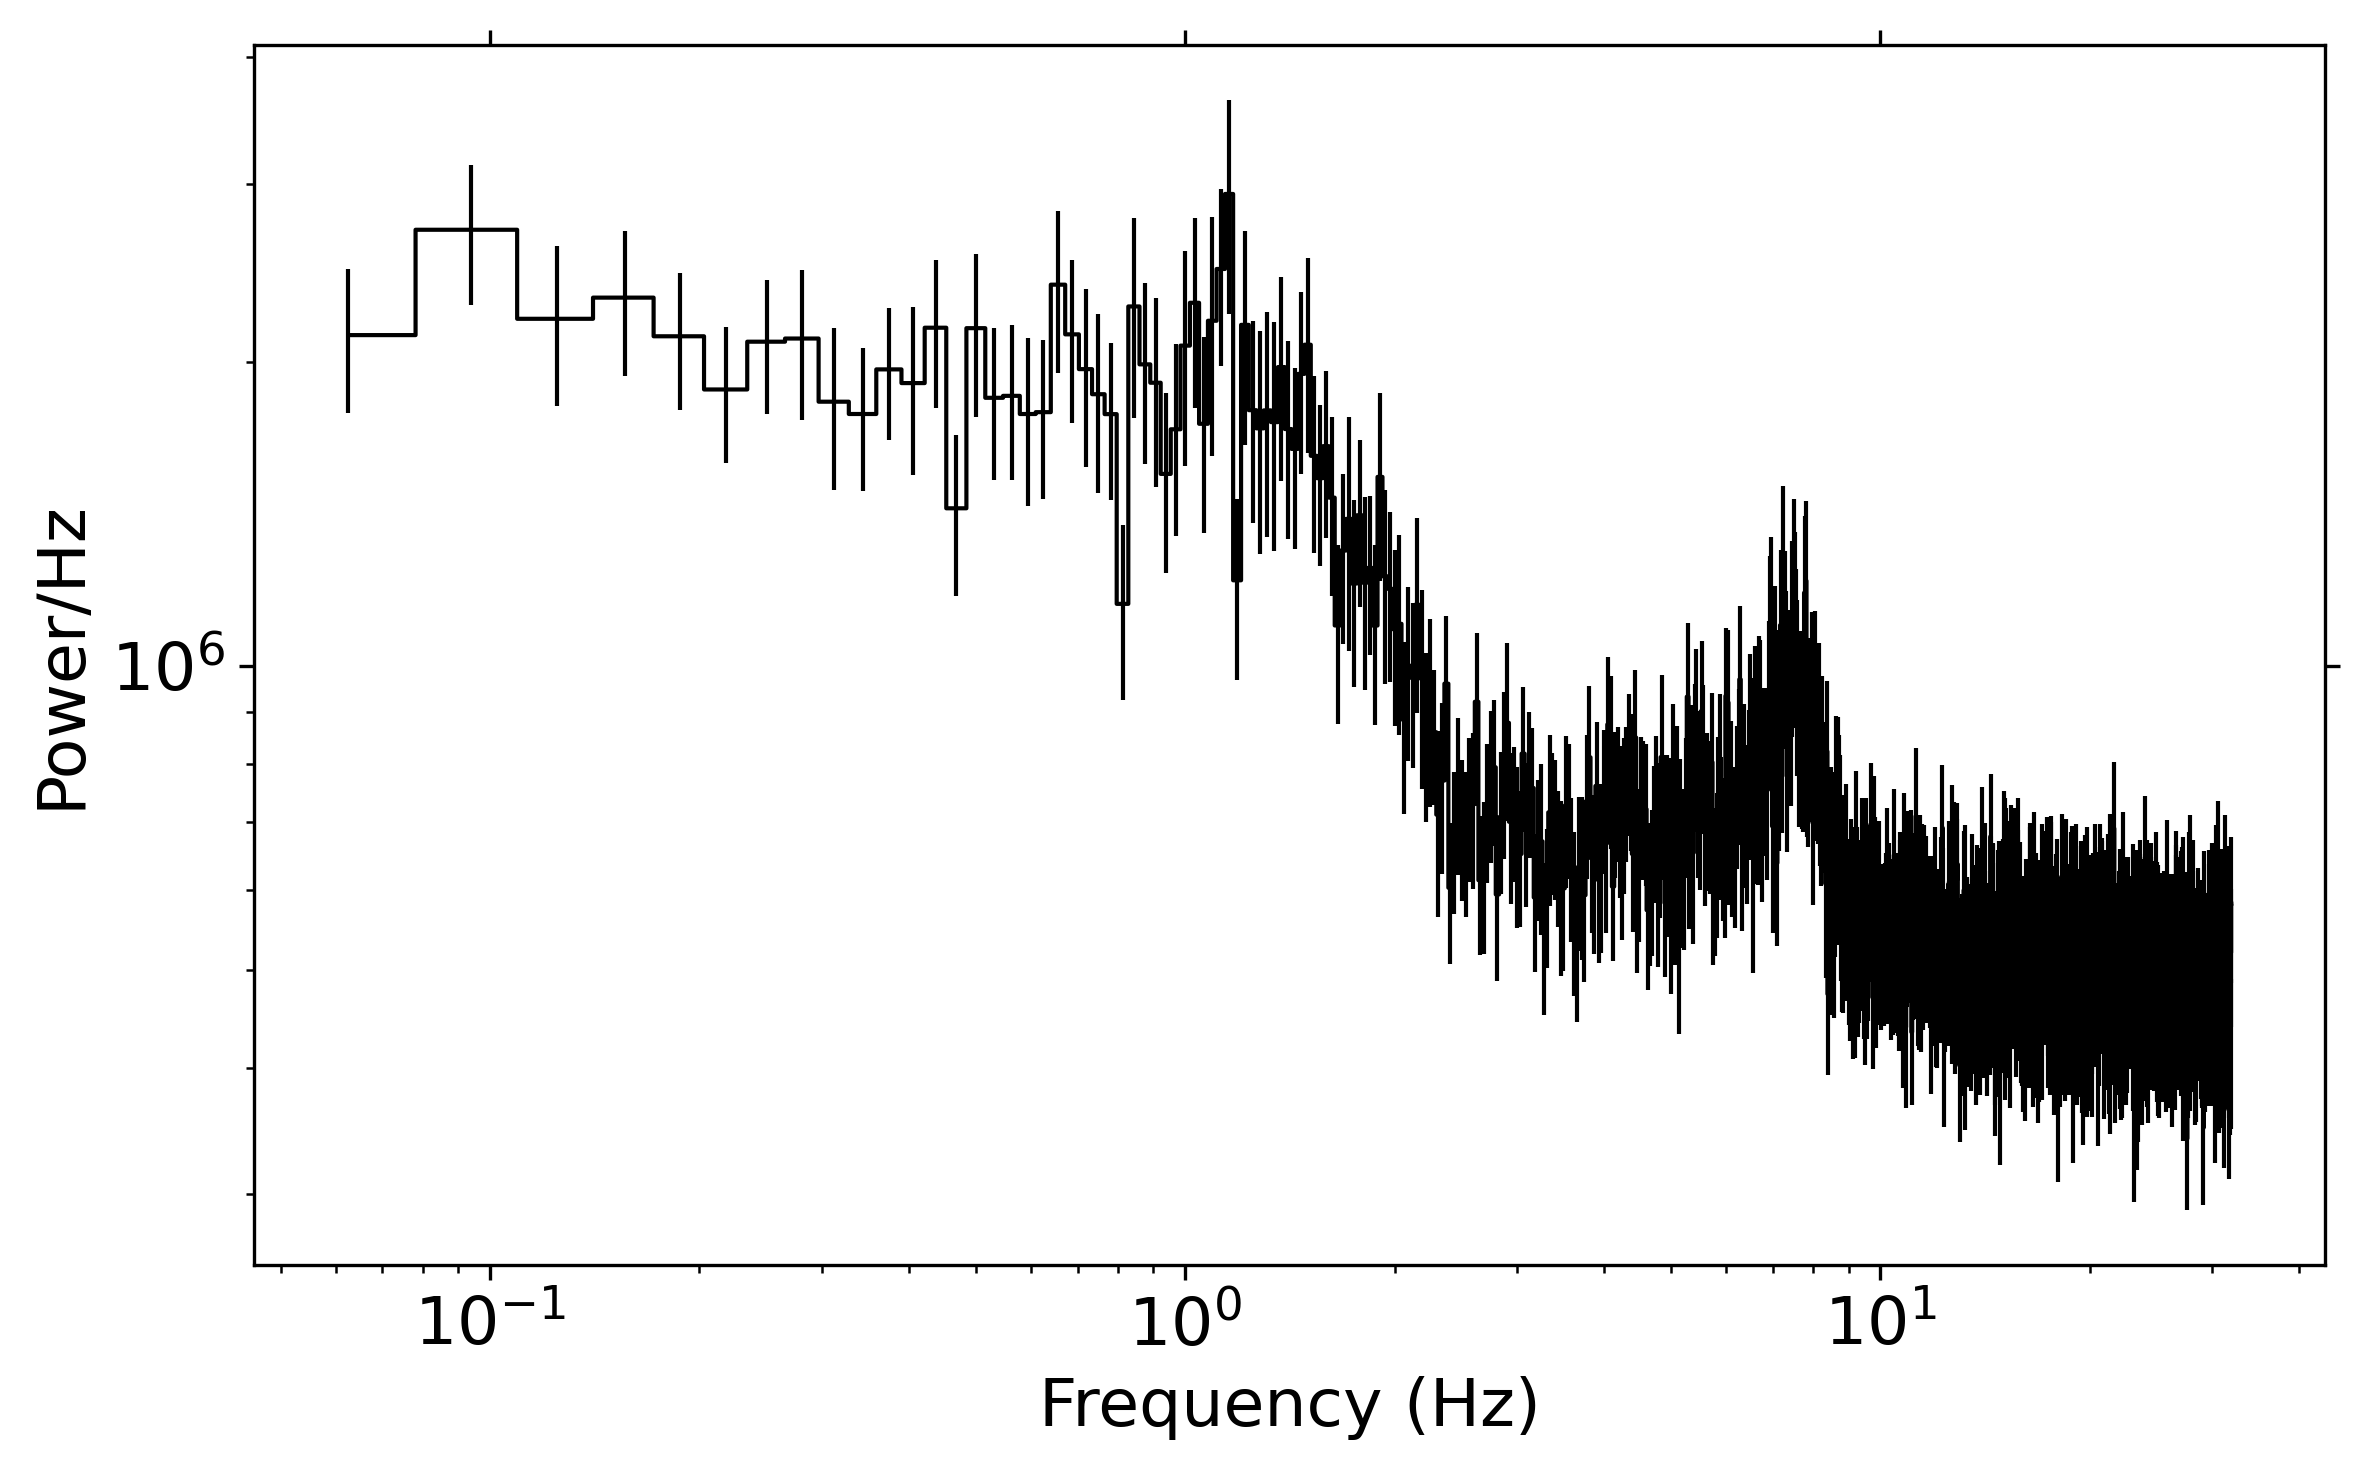

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.errorbar(ps_new.freq[1:], ps_new.power[1:], yerr=ps_new.power_err[1:], 
            lw=1, drawstyle='steps-mid', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

The thing at ~8 Hz is a low-frequency QPO, and the hump at-and-below 1 Hz is broadband noise! Now that you've got the basic analysis step complete, we'll focus on plotting the data in a meaningful way so you can easily extract information about the QPO and noise.

## 3e. Re-binning
We often plot power spectra on log-log scaled axes (so, log on both the X and Y), and you'll notice that there's a big noisy part above 10 Hz. It is common practice to bin up the power spectrum `logarithmically` (which is like making it equal-spaced in when log-plotted). 

For this written example, I'll use a re-binning factor of 0.03 (or 3%). If new bin 1 has the width of one old bin, new bin 2 will be some 3% of a bin wider. New bin 3 will be 3% wider than *that* (the width of new bin 2), etc. For the first couple bins, this will round to one old bin (since you can only have an integer number of bins), but eventually a new bin will be two old bins, then more and more as you move higher in frequency. If the idea isn't quite sticking, try drawing out a representation of old bins and how the new bins get progressively larger by the re-binning factor.

For a given new bin `x` that spans indices `a` to `b` in the old bin array: 
$$\nu_{x} = \frac{1}{b-a}\sum_{i=a}^{b}\nu_{i}$$
$$P_{x} = \frac{1}{b-a}\sum_{i=a}^{b}P_{i}$$
$$\delta P_{x} = \frac{1}{b-a}\sqrt{\sum_{i=a}^{b}(\delta P_{i})^{2}}$$

Thanks to Stingray, you don't need to code up these equations! Try using the `rebin` method for linear re-binning in frequency and `rebin_log` for logarithmically re-binning.

In [32]:
rb_ps = ps_new.rebin_log(f=0.03)

/Users/abbie/opt/anaconda3/envs/j0243/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/abbie/opt/anaconda3/envs/j0243/lib/python3.8/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


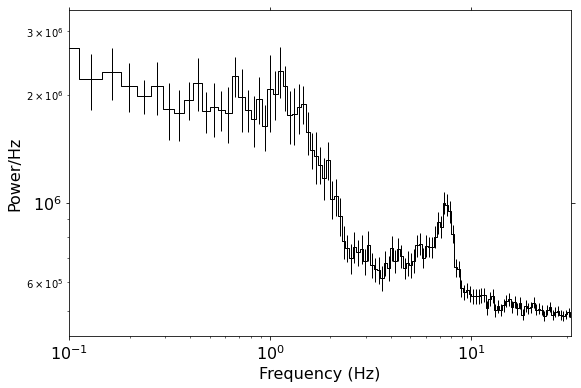

In [33]:
fig, ax2 = plt.subplots(1,1, figsize=(9,6))
ax2.errorbar(rb_ps.freq, rb_ps.power, yerr=rb_ps.power_err, lw=1, 
            drawstyle='steps-mid', color='black')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.1, rb_ps.freq[-1])
ax2.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax2.set_ylabel(r'Power/Hz', fontproperties=font_prop)
ax2.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax2.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

Play around with a few different values of the re-bin factor `f` to see how it changes the plotted power spectrum. 1 should give back exactly what you put in, and 1.1 tends to bin things up quite a lot.

Congratulations! You can make great-looking power spectra! Now, go back to part 3c. and try 4 or 5 different combinations of `dt` and `seg_length`. What happens when you pick too big of a `dt` to see the QPO frequency? What if your `seg_length` is really short?

One of the most important things to notice is that for a real astrophysical signal, the QPO (and low-frequency noise) are present for a variety of different `dt` and `seg_length` parameters. 

## 3g. Normalization
The final thing standing between us and a publication-ready power spectrum plot is the normalization of the power along the y-axis. The normalization that's commonly used is fractional rms-squared normalization. For a power spectrum created from counts/second unit light curves, the equation is:
$$P_{frac} = P \times \frac{2*dt}{N * mean^2}$$
`P` is the power we already have,
`dt` is the time step of the light curve,
`N` is the number of bins in one segment, and
`mean` is the mean count rate (in counts/s) of the light curve.

Stingray already knows this equation! Look in its documentation for normalizations. After you remake your average power spectrum from 3c.ii. with `norm=frac`, don't forget to re-bin it!

In [34]:
ps = AveragedPowerspectrum(lc_new, segment_size=32, norm='frac')
rb_ps = ps.rebin_log(f=0.03)

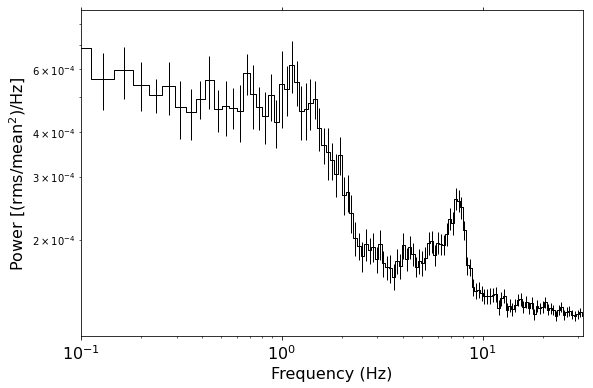

In [35]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.errorbar(rb_ps.freq, rb_ps.power, yerr=rb_ps.power_err, lw=1, 
            drawstyle='steps-mid', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, rb_ps.freq[-1])
ax.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax.set_ylabel(r'Power [(rms/mean$^{2}$)/Hz]', fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

## 3h. Poisson noise level
Notice that the Poisson noise is a power law with slope 0 at high frequencies. With this fractional rms-squared normalization, we can predict the power of the Poisson noise level from the mean counts/s rate of the light curve! 
$$P_{noise} = 2/meanrate$$

Compute this noise level (call it `poissnoise`), and plot it with the power spectrum.

In [36]:
poissnoise = 2./lc_new.meanrate

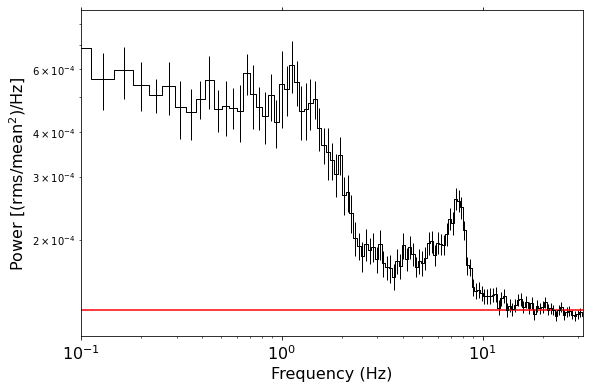

In [37]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.errorbar(rb_ps.freq, rb_ps.power, yerr=rb_ps.power_err, lw=1, 
            drawstyle='steps-mid', color='black')
ax.hlines(poissnoise, rb_ps.freq[0], rb_ps.freq[-1], color='red')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, rb_ps.freq[-1])
ax.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax.set_ylabel(r'Power [(rms/mean$^{2}$)/Hz]', fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

Your horizontal Poisson noise line should be really close to the power at and above ~10 Hz.

## 3i.  For plotting purposes, we sometimes subtract the Poisson noise level from the power before plotting. 
Once we've done this and removed the noise, we can also plot the data in units of Power, instead of Power/Hz, by multiplying the power by the frequency. Recall that following the propagation of errors, you will need to multiply the error by the frequency as well, but not subtract the Poisson noise level there.

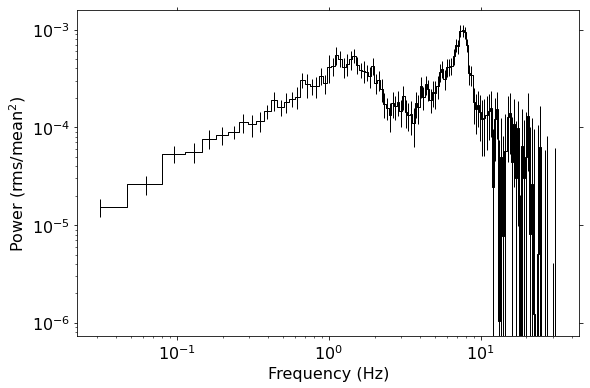

In [38]:
nuPnu = (rb_ps.power - poissnoise) * rb_ps.freq
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.errorbar(rb_ps.freq, nuPnu, yerr=rb_ps.power_err*rb_ps.freq, lw=1, 
            drawstyle='steps-mid', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax.set_ylabel(r'Power (rms/mean$^{2}$)', fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

Beautiful! This lets us see the components clearly above the noise and see their *relative* contributions to the power spectrum (and thus to the light curve).

## Recap of what you learned in problem 3: 
You are now able to take a light curve, break it into appropriate segments using the given Good Time Intervals, compute the average power spectrum (without weird aliasing artefacts), and plot it in such away that you can see the signals clearly.

# Problem 4: It's pulsar time
We are going to take these skills and now work on two different observations of the same source, the ultra-luminous X-ray pulsar Swift J0243.6+6124. The goal is for you to see how different harmonics in the pulse shape manifest in the power spectrum.

## 4a. Load the data and GTI
Using the files J0243-122_evt.fits and J0243-134_evt.fits, and the corresponding *x*_gti.fits.

In [39]:
j0243_1 = Table.read("./J0243-122_evt.fits", format='fits')
gti_1 = Table.read("./J0243-122_gti.fits", format='fits')
j0243_2 = Table.read("./J0243-134_evt.fits", format='fits')
gti_2 = Table.read("./J0243-134_gti.fits", format='fits')

## 4b. Apply a mask to remove energies below 0.5 keV and above 12 keV.

In [40]:
energy_mask_1 = (j0243_1['ENERGY'] >= 50) & (j0243_1['ENERGY'] <= 1200)
j0243_1 = j0243_1[energy_mask_1]
energy_mask_2 = (j0243_2['ENERGY'] >= 50) & (j0243_2['ENERGY'] <= 1200)
j0243_2 = j0243_2[energy_mask_2]

## 4c. Make the average power spectrum for each data file.
Go through in the same way as 3c. The spin period is 10 seconds, so I don't recommend using a segment length shorter than that (try 64 seconds). Since the period is quite long (for a pulsar), you can use a longer `dt`, like 1/8 seconds, and use `frac` normalization. Use the same segment length and dt for both data sets. Re-bin your averaged power spectrum.

In [41]:
gti1 = [[i,j] for (i,j) in zip(gti_1['START'], gti_1['STOP'])]
gti2 = [[l,m] for (l,m) in zip(gti_2['START'], gti_2['STOP'])]
lc_1 = Lightcurve.make_lightcurve(j0243_1['TIME'], dt=1./8, gti=gti1)
ps_1 = AveragedPowerspectrum(lc_1, segment_size=64, norm='frac')
lc_2 = Lightcurve.make_lightcurve(j0243_2['TIME'], dt=1./8, gti=gti2)
ps_2 = AveragedPowerspectrum(lc_2, segment_size=64, norm='frac')

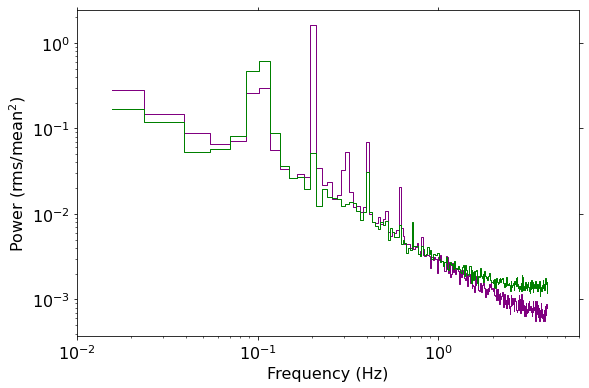

In [42]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.errorbar(ps_1.freq, ps_1.power, lw=1, 
            drawstyle='steps-mid', color='purple')
ax.errorbar(ps_2.freq, ps_2.power, lw=1, 
            drawstyle='steps-mid', color='green')
## Plotting without error bars for now
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 6)
ax.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax.set_ylabel(r'Power (rms/mean$^{2}$)', fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

Side note: if you don't normalize them (`none`), notice how the countrate of the light curve correlates with the power.

## 4d. Make a phase-folded light curve the brute force way
### 4d.i. Spin period
Determine the spin period from the frequency of the lowest (fundamental) tone in the power spectrum. Remember that period=1/f. Hint: `np.argmax` is a great function for quick, brute-force things.

In [43]:
spin_f = ps_2.freq[np.argmax(ps_2.power[0:10])]
period = 1./spin_f

### 4d.ii. Relative phases
Use the modulo operator of the light curve (starting it at time zero) to determine the relative phase of each photon event, then divide by the period to have relative phase from 0 to 1.

In [44]:
rel_time1 = np.asarray(j0243_1['TIME']) - j0243_1['TIME'][0]
rel_phase1 = (rel_time1 % period) / period
rel_time2 = np.asarray(j0243_2['TIME']) - j0243_2['TIME'][0]
rel_phase2 = (rel_time2 % period) / period

### 4d.iii. Binning
Make an array of 20 phase bins and put the relative phases in their phase bins with `np.histogram`.

In [45]:
phase1, bins1 = np.histogram(rel_phase1, bins=20, range=(0, 1))
phase2, bins2 = np.histogram(rel_phase2, bins=20, range=(0, 1))

### 4d.iv. Plot the light curve next to its accompanying power spectrum

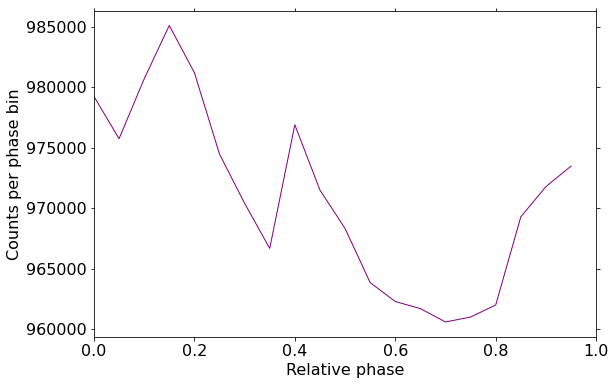

In [46]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(bins1[0:-1], phase1, lw=1, color='purple')
ax.set_xlabel(r'Relative phase', fontproperties=font_prop)
ax.set_ylabel(r'Counts per phase bin', fontproperties=font_prop)
ax.set_xlim(0, 1)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

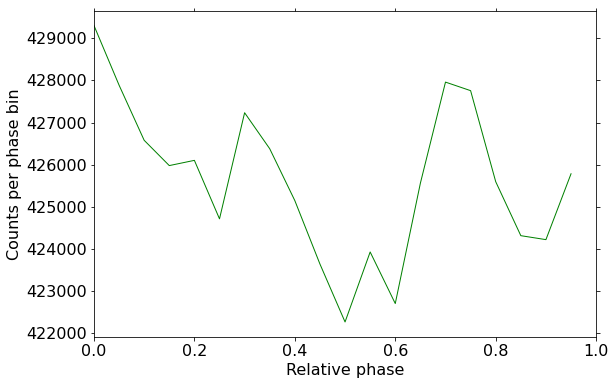

In [47]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(bins2[0:-1], phase2, lw=1, color='green')
ax.set_xlabel(r'Relative phase', fontproperties=font_prop)
ax.set_ylabel(r'Counts per phase bin', fontproperties=font_prop)
ax.set_xlim(0, 1)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
                labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
                labelleft=True, labelright=False)
plt.show()

Though these are very quickly made phase-folded light curves, you can see how the light curve with stronger harmonic content shows more power at the harmonic frequency in the power spectrum, and the light curve that's more asymmetric in rise and fall times (number 1) shows power at higher harmonics!

If you want to see what a real phase-folded pulse profile looks like for these data, check out the beautiful plots in Wilson-Hodge et al. 2018: https://ui.adsabs.harvard.edu/abs/2018ApJ...863....9W/abstract
Data set 1 has an observation ID that ends in 122 and corresponds to MJD 58089.626, and data set 2 has an observation ID that ends in 134 and corresponds to MJD 58127.622.

# Bonus challenges:
### 5. Dynamical power spectrum (/spectrogram): 
Instead of averaging the power spectra at each segment, save it into a dynamical power spectrum (also called a spectrogram) using `DynamicalPowerspectrum` in Stingray. Apply the normalization (see if you can re-bin it), then make a 3d plot with frequency along the y-axis, segment (which corresponds to elapsed time) along the x-axis, and power as the colormap. Don't subtract the Poisson noise before plotting here, since some segments will have noisy power below the Poisson noise level, and then you're trying to plot negative numbers on a log scale, which is a very bad idea.

This approach is useful if you think the QPO turns on and off rapidly (high-frequency QPOs do this) or is changing its frequency on short timescales. If the frequency is changing, this can artificially broaden the Lorentzian-shaped peak we see in the average power spectrum. Or, sometimes it's intrinsically broad. A look at the dynamical power spectrum will tell you! This will be most interesting on the black hole J1535 data, but could be done for both objects.
### 6. Energy bands:
Make and plot power spectra of the same object using light curves of different energy bands. For example, try 1-2 keV, 2-4 keV, and 4-12 keV. Try to only loop through the event list once as you do the analysis for all three bands. What do you notice about the energy dependence of the signal?
### 7. Modeling:
Using astropy.modeling or stingray.modeling (or your own preferred modeling package), fit the power spectrum of the black hole J1535 with a Lorentzian for the QPO, a few Lorentzians for the low-frequency broadband noise, and a power law for the Poisson noise level. In papers we often report the centroid frequency and the full-width at half maximum (FWHM) of the QPO Lorentzian model. How would you rule out the presence of a QPO at, e.g., 12 Hz?
### 8. Data visualization:
Add a legend to the power spectra plot in problem 1, so that the label for the color gives the corresponding $\zeta$.
### 9. Poisson noise:
Go through problem 2 and use `np.random.poisson` to apply Poisson noise to the signals (`oscill` and the four `damp`), and take the power spectra again, and plot them. Then try using the information in problem 3 about the Poisson noise level as it relates to the average count rate of the light curve to calculate and plot them together.
### 10. Stingray phase-folded light curves:
Looking through the Stingray documentation (and possibly HENDRICS), find a more elegant way to make phase-folded pulsar light curves.